Code: https://github.com/juanjosegarciaripoll/suppl-quantum-inspired-methods/blob/master/02%20MPS%20discussion.ipynb
seemps code: https://github.com/juanjosegarciaripoll/seemps/blob/master/mps/mpo.py

maximal bond dimension and printing (or not) information about MPS actualization:

In [2]:
mbd = 40
mbd2 = 40
printinfo = False

# Code for MPS, MPOs, and ladder operators:


In [3]:
import numpy as np
import copy
import scipy.linalg
import scipy.sparse as sp

import math
import matplotlib.pyplot as plt
from scipy.integrate import simps
from math import pi as π
epsilon = np.finfo(np.float64).eps
from scipy.special import erf
from numpy import cos, sin, exp
import os.path

get MPOlist, MPOsum and expectation (expectation.py):

In [4]:
def begin_environment(χ=1):
    """Initiate the computation of a left environment from two MPS. The bond
    dimension χ defaults to 1. Other values are used for states in canonical
    form that we know how to open and close."""
    return np.eye(χ, dtype=np.float64)

def update_left_environment(B, A, rho, operator=None):
    """Extend the left environment with two new tensors, 'B' and 'A' coming
    from the bra and ket of a scalar product. If an operator is provided, it
    is contracted with the ket."""
    if operator is not None:
        A = np.einsum("ji,aib->ajb", operator, A)
    rho = np.einsum("li,ijk->ljk", rho, A)
    return np.einsum("lmn,lmk->nk", B.conj(), rho)

def update_right_environment(B, A, rho, operator=None):
    """Extend the left environment with two new tensors, 'B' and 'A' coming
    from the bra and ket of a scalar product. If an operator is provided, it
    is contracted with the ket."""
    if operator is not None:
        A = np.einsum("ji,aib->ajb", operator, A)
    rho = np.einsum("ijk,kn->ijn", A, rho)
    return np.einsum("ijn,ljn->il", rho, B.conj())

def end_environment(ρ):
    """Extract the scalar product from the last environment."""
    return ρ[0,0]

def join_environments(ρL, ρR):
    """Join left and right environments to produce a scalar."""
    return np.einsum('ij,ji', ρL, ρR)

def scprod(ϕ, ψ):
    """Compute the scalar product between matrix product states <ϕ|ψ>."""
    ρ = begin_environment()
    for i in range(ψ.size):
        ρ = update_left_environment(ϕ[i], ψ[i], ρ)
    return end_environment(ρ)

def expectation1(ψ, O, site):
    """Compute the expectation value <ψ|O|ψ> of an operator O acting on 'site'"""
    ρL = ψ.left_environment(site)
    A = ψ[site]
    OL = update_left_environment(A, A, ρL, operator=O)
    ρR = ψ.right_environment(site)
    return join_environments(OL, ρR)

def expectation2(ψ, O, Q, i, j=None):
    """Compute the expectation value <ψ|O_i Q_j|ψ> of an operator O acting on
    sites 'i' and 'j', with 'j' defaulting to 'i+1'"""
    if j is None:
        j = i+1
    elif j == i:
        return expectation1(ψ, O @ Q, i)
    elif j < i:
        i, j = j,i
    OQL = ψ.left_environment(i)
    for ndx in range(i,j+1):
        A = ψ[ndx]
        if ndx == i:
            OQL = update_left_environment(A, A, OQL, operator=O)
        elif ndx == j:
            OQL = update_left_environment(A, A, OQL, operator=Q)
        else:
            OQL = update_left_environment(A, A, OQL)
    return join_environments(OQL, ψ.right_environment(j))

def get_operator(O, i):
    #
    # This utility function is used to guess the operator acting on site 'i'
    # If O is a list, it corresponds to the 'i'-th element. Otherwise, we
    # use operator 'O' everywhere.
    #
    if type(O) == list:
        return O[i]
    else:
        return O

def all_expectation1(ψ, O, tol=0):
    """Return all expectation values of operator O acting on ψ. If O is a list
    of operators, a different one is used for each site."""

    Oenv = []
    ρ = begin_environment()
    allρR = [ρ] * ψ.size
    for i in range(ψ.size-1,0,-1):
        A = ψ[i]
        ρ = update_right_environment(A, A, ρ)
        allρR[i-1] = ρ

    ρL = begin_environment()
    output = allρR
    for i in range(ψ.size):
        A = ψ[i]
        ρR = allρR[i]
        OρL = update_left_environment(A, A, ρL, operator=get_operator(O,i))
        output[i] = join_environments(OρL, ρR)
        ρL = update_left_environment(A, A, ρL)
    return np.array(output)

def product_expectation(ψ, operator_list):
    rho = begin_environment(ρ)

    for i in range(ψ.size):
        rho = update_left_environment(ψ[i].conj(), ψ[i], rho, operator = operator_list[i])

    return close_environment(ρ)

for MPO, get TensorArray from state.py:

In [5]:
DEFAULT_TOLERANCE = np.finfo(np.float64).eps

def vector2mps(ψ, dimensions, tolerance=DEFAULT_TOLERANCE, normalize=True):
    """Construct a list of tensors for an MPS that approximates the state ψ
    represented as a complex vector in a Hilbert space.

    Parameters
    ----------
    ψ         -- wavefunction with \prod_i dimensions[i] elements
    dimensions -- list of dimensions of the Hilbert spaces that build ψ
    tolerance -- truncation criterion for dropping Schmidt numbers
    normalize -- boolean to determine if the MPS is normalized
    """

    def SchmidtSplit(ψ, tolerance):
        a, b = ψ.shape
        U, s, V = scipy.linalg.svd(
            ψ,
            full_matrices=False,
            check_finite=False,
            overwrite_a=True,
            lapack_driver="gesdd",
        )
        s, err = _truncate_vector(s, tolerance, None)
        D = s.size
        return np.reshape(U[:, :D], (a, D)), np.reshape(s, (D, 1)) * V[:D, :]

    Da = 1
    dimensions = np.array(dimensions, dtype=np.int)
    Db = np.prod(dimensions)
    output = [0] * len(dimensions)
    for (i, d) in enumerate(dimensions[:-1]):
        # We split a new subsystem and group the left bond dimension
        # and the physical index into a large index
        ψ = np.reshape(ψ, (Da * d, int(Db / d)))
        #
        # We then split the state using the Schmidt decomposition. This
        # produces a tensor for the site we are looking at and leaves
        # us with a (hopefully) smaller state for the rest
        A, ψ = SchmidtSplit(ψ, tolerance)
        output[i] = np.reshape(A, (Da, d, A.shape[1]))
        Da, Db = ψ.shape

    output[-1] = np.reshape(ψ, (Da, Db, 1))
    if normalize == True:
        output[-1] /= np.linalg.norm(ψ)

    return output


def _truncate_vector(S, tolerance, max_bond_dimension=mbd):
    """Given a vector of Schmidt numbers `S`, a `tolerance` and a maximum
    bond `max_bond_dimension`, determine where to truncate the vector and return
    the absolute error in norm-2 made by that truncation.

    Parameters
    ----------
    S         -- non-negative Schmidt numbers in decreasing order.
    tolerance -- absolute error allowed by the truncation
    max_bond_dimension -- maximum bond dimension (or None)

    Output
    ------
    S         -- new, truncated vector of Schmidt numbers
    error     -- norm-2 error made by the truncation
    """
    if tolerance == 0:
        #log('--no truncation')
        return S, 0
    # We sum all reduced density matrix eigenvalues, starting from
    # the smallest ones, to avoid rounding errors
    err = np.cumsum(S[::-1] ** 2)
    #
    # This is the sum of all values
    total = err[-1]
    #
    # The vector err[0],err[1],...,err[k] is the error that we make
    # by keeping the singular values from 0 to N-k
    # We find the first position that is above tolerance err[k],
    # which tells us which is the smallest singular value that we
    # have to keep, s[k-1]
    #
    ndx = np.argmax(err >= tolerance*total)
    if max_bond_dimension is not None:
        ndx = max(ndx, S.size - max_bond_dimension)
    #
    # We use that to estimate the size of the array and the actual error
    #
    return S[0:(S.size - ndx)], err[ndx-1] if ndx else 0.


class TensorArray(object):
    """TensorArray class.

    This class provides the basis for all tensor networks. The class abstracts
    a one-dimensional array of tensors that is freshly copied whenever the
    object is cloned. Two TensorArray's can share the same tensors and be
    destructively modified.

    Attributes:
    size = number of tensors in the array
    """

    def __init__(self, data):
        """Create a new TensorArray from a list of tensors. `data` is an
        iterable object, such as a list or other sequence. The list is cloned
        before storing it into this object, so as to avoid side effects when
        destructively modifying the array."""
        self._data = list(data)
        self.size = len(self._data)

    def __getitem__(self, k):
        #
        # Get MP matrix at position `k`. If 'A' is an MP, we can now
        # do A[k]
        #
        return self._data[k]

    def __setitem__(self, k, value):
        #
        # Replace matrix at position `k` with new tensor `value`. If 'A'
        # is an MP, we can now do A[k] = value
        #
        self._data[k] = value
        return value

    def __copy__(self):
        #
        # Return a copy of the MPS with a fresh new array.
        #
        return type(self)(self._data)

    def __len__(self):
        return self.size

    def copy(self):
        """Return a fresh new TensorArray that shares the same tensor as its
        sibling, but which can be destructively modified without affecting it.
        """
        return self.__copy__()


class MPS(TensorArray):
    """MPS (Matrix Product State) class.

    This implements a bare-bones Matrix Product State object with open
    boundary conditions. The tensors have three indices, `A[α,i,β]`, where
    `α,β` are the internal labels and `i` is the physical state of the given
    site.

    Parameters
    ----------
    data    -- A list of tensors that form the MPS. The class assumes they
               have three legs and are well formed--i.e. the bond dimensions
               of neighboring sites match.
    error   -- Accumulated error of the simplifications of the MPS.
    maxsweeps, tolerance, normalize, max_bond_dimension -- arguments used by
                 the simplification routine, if simplify is True.
    """

    #
    # This class contains all the matrices and vectors that form
    # a Matrix-Product State.
    #
    __array_priority__ = 10000
    def __init__(self, data, error=0, maxsweeps=16,
                 tolerance=DEFAULT_TOLERANCE,
                 normalize=False, max_bond_dimension=mbd):
        super(MPS, self).__init__(data)
        assert data[0].shape[0] == data[-1].shape[-1] == 1
        self._error = error
        self.maxsweeps = maxsweeps
        self.tolerance = tolerance
        self.normalize = normalize
        self.max_bond_dimension = max_bond_dimension

    def dimension(self):
        """Return the total size of the Hilbert space in which this MPS lives."""
        return np.product([a.shape[1] for a in self._data])

    def tovector(self):
        """Return one-dimensional complex vector of dimension() elements, with
        the complete wavefunction that is encoded in the MPS."""
        return _mps2vector(self)

    @staticmethod
    def fromvector(ψ, dimensions, **kwdargs):
        return MPS(vector2mps(ψ, dimensions, **kwdargs))

    def __add__(self,φ):
        """Add an MPS or an MPSSum to the MPS.

        Parameters
        ----------
        φ    -- MPS or MPSSum object.

        Output
        ------
        mps_list    -- New MPSSum.
        """
        maxsweeps = min(self.maxsweeps, φ.maxsweeps)
        tolerance = min(self.tolerance, φ.tolerance)
        if self.max_bond_dimension is None:
            max_bond_dimension = φ.max_bond_dimension
        elif φ.max_bond_dimension is None:
            max_bond_dimension = self.max_bond_dimension
        else:
            max_bond_dimension = min(self.max_bond_dimension, φ.max_bond_dimension)
        if isinstance(φ,MPS):
            new_weights = [1,1]
            new_states = [self,φ]
        elif isinstance(φ,MPSSum):
            new_weights = [1] + φ.weights
            new_states = [self] + φ.states
        new_MPSSum = MPSSum(weights=new_weights,states=new_states,
                      maxsweeps=maxsweeps,tolerance=tolerance,
                      normalize=self.normalize, max_bond_dimension=max_bond_dimension)
        return new_MPSSum

    def __sub__(self,φ):
        """Subtract an MPS or an MPSSum from the MPS.

        Parameters
        ----------
        φ    -- MPS or MPSSum object.

        Output
        ------
        mps_list    -- New MPSSum.
        """
        maxsweeps = min(self.maxsweeps, φ.maxsweeps)
        tolerance = min(self.tolerance, φ.tolerance)
        if self.max_bond_dimension is None:
            max_bond_dimension = φ.max_bond_dimension
        elif φ.max_bond_dimension is None:
            max_bond_dimension = self.max_bond_dimension
        else:
            max_bond_dimension = min(self.max_bond_dimension, φ.max_bond_dimension)
        if isinstance(φ,MPS):
            new_weights = [1,-1]
            new_states = [self,φ]
        elif isinstance(φ,MPSSum):
            new_weights = [1]  + list((-1) * np.asarray(φ.weights))
            new_states = [self] + φ.states
        new_MPSSum = MPSSum(weights=new_weights,states=new_states,
                      maxsweeps=maxsweeps,tolerance=tolerance,
                      normalize=self.normalize, max_bond_dimension=max_bond_dimension)
        return new_MPSSum

    def __mul__(self,n):
        """Multiply an MPS quantum state by an scalar n (MPS * n)

        Parameters
        ----------
        n    -- Scalar to multiply the MPS by.

        Output
        ------
        mps    -- New mps.
        """
        if not np.isscalar(n):
            raise Exception(f'Cannot multiply MPS by {n}')
        mps_mult = copy.deepcopy(self)
        mps_mult._data[0] = n*mps_mult._data[0]
        mps_mult._error = np.abs(n)**2 * mps_mult._error
        return mps_mult

    def __rmul__(self,n):
        """Multiply an MPS quantum state by an scalar n (n * MPS).

        Parameters
        ----------
        n    -- Scalar to multiply the MPS by.

        Output
        ------
        mps    -- New mps.
        """
        if not np.isscalar(n):
            raise Exception(f'Cannot multiply MPS by {n}')
        mps_mult = copy.deepcopy(self)
        mps_mult._data[0] = n*mps_mult._data[0]
        mps_mult._error = np.abs(n)**2 * mps_mult._error
        return mps_mult

    def norm2(self):
        """Return the square of the norm-2 of this state, ‖ψ‖^2 = <ψ|ψ>."""
        return scprod(self, self)

    def expectation1(self, operator, n):
        """Return the expectation value of `operator` acting on the `n`-th
        site of the MPS. See `mps.expectation.expectation1()`."""
        return expectation1(self, operator, n)

    def expectation2(self, operator1, operator2, i, j=None):
        """Return the expectation value of `operator1` and `operator2` acting
        on the sites `i` and `j`. See `mps.expectation.expectation2()`"""
        return expectation2(self, operator1, operator2, i, j)

    def all_expectation1(self, operator):
        """Return all expectation values of `operator` acting on all possible
        sites of the MPS. See `mps.expectation.all_expectation1()`."""
        return all_expectation1(self, operator)

    def left_environment(self, site):
        ρ = begin_environment()
        for A in self[:site]:
            ρ = update_left_environment(A, A, ρ)
        return ρ

    def right_environment(self, site):
        ρ = begin_environment()
        for A in self[-1:site:-1]:
            ρ = update_right_environment(A, A, ρ)
        return ρ

    def error(self):
        """Return any recorded norm-2 truncation errors in this state. More
        precisely, ‖exact - actual‖^2."""
        return self._error

    def update_error(self, delta):
        """Update an estimate of the norm-2 truncation errors. We use the
        triangle inequality to guess an upper bound."""
        self._error = (np.sqrt(self._error)+np.sqrt(delta))**2
        return self._error

    def extend(self, L, sites=None, dimensions=2):
        """Enlarge an MPS so that it lives in a Hilbert space with `L` sites.

        Parameters
        ----------
        L          -- The new size
        dimensions -- If it is an integer, it is the dimension of the new sites.
                      If it is a list, it is the dimension of all sites.
        sites      -- Where to place the tensors of the original MPO.

        Output
        ------
        mpo        -- A new MPO.
        """
        assert L >= self.size
        if np.isscalar(dimensions):
            dimensions = [dimensions] * L
        if sites is None:
            sites = range(self.size)
        else:
            assert len(sites) == self.size

        data = [None]*L
        for (ndx, A) in zip(sites, self):
            data[ndx] = A
            dimensions[ndx] = A.shape[1]
        D = 1
        for (i, A) in enumerate(data):
            if A is None:
                d = dimensions[i]
                A = np.zeros((D,d,D))
                A[:,0,:] = np.eye(D)
                data[i] = A
            else:
                D = A.shape[-1]
        return MPS(data)


def _mps2vector(data):
    #
    # Input:
    #  - data: list of tensors for the MPS (unchecked)
    # Output:
    #  - Ψ: Vector of complex numbers with all the wavefunction amplitudes
    #
    # We keep Ψ[D,β], a tensor with all matrices contracted so far, where
    # 'D' is the dimension of the physical subsystems up to this point and
    # 'β' is the last uncontracted internal index.
    #
    Ψ = np.ones((1, 1,))
    D = 1
    for (i, A) in enumerate(data):
        α, d, β = A.shape
        Ψ = np.einsum('Da,akb->Dkb', Ψ, A)
        D = D * d
        Ψ = np.reshape(Ψ, (D, β))
    return Ψ.reshape((Ψ.size,))

class MPSSum():
    """MPSSum class.

    Stores the MPS as a list  for its future combination when an MPO acts on it.

    Parameters
    ----------
    weights    -- weights of the linear combination of MPS.
    states    --  states of the linear combination of MPS.
    maxsweeps, tolerance, normalize, max_bond_dimension -- arguments used by
                 the simplification routine, if simplify is True.
    """

    #
    # This class contains all the matrices and vectors that form
    # a Matrix-Product State.
    #
    __array_priority__ = 10000
    def __init__(self, weights, states, maxsweeps=16,
                 tolerance=DEFAULT_TOLERANCE,
                 normalize=False, max_bond_dimension=mbd):
        self.weights = weights
        self.states = states
        self.maxsweeps = maxsweeps
        self.tolerance = tolerance
        self.normalize = normalize
        self.max_bond_dimension = max_bond_dimension

    def __add__(self,φ):
        """Add an MPS or an MPSSum to the MPSSum.

        Parameters
        ----------
        φ    -- MPS or MPSSum object.

        Output
        ------
        mps_list    -- New MPSSum.
        """
        maxsweeps = min(self.maxsweeps, φ.maxsweeps)
        tolerance = min(self.tolerance, φ.tolerance)
        if self.max_bond_dimension is None:
            max_bond_dimension = φ.max_bond_dimension
        elif φ.max_bond_dimension is None:
            max_bond_dimension = self.max_bond_dimension
        else:
            max_bond_dimension = min(self.max_bond_dimension, φ.max_bond_dimension)
        if isinstance(φ,MPS):
            new_weights = self.weights + [1]
            new_states = self.states + [φ]
        elif isinstance(φ,MPSSum):
            new_weights = self.weights + φ.weights
            new_states = self.states + φ.states
        new_MPSSum = MPSSum(weights=new_weights,states=new_states,
                      maxsweeps=maxsweeps,tolerance=tolerance,
                      normalize=self.normalize, max_bond_dimension=self.max_bond_dimension)
        return new_MPSSum

    def __sub__(self,φ):
        """Subtract an MPS or an MPSSum from the MPSSum.

        Parameters
        ----------
        φ    -- MPS or MPSSum object.

        Output
        ------
        mps_list    -- New MPSSum.
        """
        maxsweeps = min(self.maxsweeps, φ.maxsweeps)
        tolerance = min(self.tolerance, φ.tolerance)
        if self.max_bond_dimension is None:
            max_bond_dimension = φ.max_bond_dimension
        elif φ.max_bond_dimension is None:
            max_bond_dimension = self.max_bond_dimension
        else:
            max_bond_dimension = min(self.max_bond_dimension, φ.max_bond_dimension)
        if isinstance(φ,MPS):
            new_weights = self.weights + [-1]
            new_states = self.states + [φ]
        elif isinstance(φ,MPSSum):
            new_weights = self.weights + list((-1) * np.asarray(φ.weights))
            new_states = self.states + φ.states
        new_MPSSum = MPSSum(weights=new_weights,states=new_states,
                      maxsweeps=maxsweeps,tolerance=tolerance,
                      normalize=self.normalize, max_bond_dimension=self.max_bond_dimension)
        return new_MPSSum

    def __mul__(self,n):
        """Multiply an MPSSum quantum state by an scalar n (MPSSum * n)

        Parameters
        ----------
        n    -- Scalar to multiply the MPSSum by.

        Output
        ------
        mps    -- New mps.
        """
        if not np.isscalar(n):
            raise Exception(f'Cannot multiply MPSSum by {n}')
        new_states = [n * mps for mps in self.states]
        new_MPSSum = MPSSum(weights=self.weights,states=new_states,
                          maxsweeps=self.maxsweeps,tolerance=self.tolerance,
                          normalize=self.normalize, max_bond_dimension=self.max_bond_dimension)
        return new_MPSSum

    def __rmul__(self,n):
        """Multiply an MPSSum quantum state by an scalar n (n * MPSSum).

        Parameters
        ----------
        n    -- Scalar to multiply the MPSSum by.

        Output
        ------
        mps    -- New mps.
        """
        if not np.isscalar(n):
            raise Exception(f'Cannot multiply MPSSum by {n}')
        new_states = [n * mps for mps in self.states]
        new_MPSSum = MPSSum(weights=self.weights,states=new_states,
                          maxsweeps=self.maxsweeps,tolerance=self.tolerance,
                          normalize=self.normalize, max_bond_dimension=self.max_bond_dimension)
        return new_MPSSum

    def toMPS(self, normalize=None):
        if normalize is None:
            normalize = self.normalize
        ψ, _ = combine(
            self.weights,
            self.states,
            maxsweeps=self.maxsweeps,
            tolerance=self.tolerance,
            normalize=normalize,
            max_bond_dimension=self.max_bond_dimension,
        )
        return ψ


def product(vectors, length=None):
    #
    # If `length` is `None`, `vectors` will be a list of complex vectors
    # representing the elements of the product state.
    #
    # If `length` is an integer, `vectors` is a single complex vector and
    # it is repeated `length` times to build a product state.
    #
    def to_tensor(v):
        v = np.array(v)
        return np.reshape(v, (1, v.size, 1))

    if length is not None:
        return MPS([to_tensor(vectors)] * length)
    else:
        return MPS([to_tensor(v) for v in vectors])



def GHZ(n):
    """Return a GHZ state with `n` qubits in MPS form."""
    a = np.zeros((2, 2, 2))
    b = a.copy()
    a[0, 0, 0] = a[0, 1, 1] = 1.0/np.sqrt(2.0)
    b[0, 0, 0] = 1.0
    b[1, 1, 1] = 1.0
    data = [a]+[b] * (n-1)
    data[0] = a[0:1, :, :]
    b = data[n-1]
    data[n-1] = (b[:, :, 1:2] + b[:, :, 0:1])
    return MPS(data)


def W(n):
    """Return a W with one excitation over `n` qubits."""
    a = np.zeros((2, 2, 2))
    a[0, 0, 0] = 1.0
    a[0, 1, 1] = 1.0/np.sqrt(n)
    a[1, 0, 1] = 1.0
    data = [a] * n
    data[0] = a[0:1, :, :]
    data[n-1] = data[n-1][:, :, 1:2]
    return MPS(data)



def wavepacket(ψ):
    #
    # Create an MPS for a spin 1/2 system with the given amplitude
    # of the excited state on each site. In other words, we create
    #
    #   \sum_i Ψ[i] σ^+ |0000...>
    #
    # The MPS is created with a single tensor: A(i,s,j)
    # The input index "i" can take two values, [0,1]. If it is '0'
    # it means we have not applied any σ^+ anywhere else, and we can
    # excite a spin here. Therefore, we have two possible values:
    #
    #   A(0,0,0) = 1.0
    #   A(0,1,1) = ψ[n] (n=given site)
    #
    # If i=1, then we cannot excite any further spin and
    #   A(1,0,1) = 1.0
    #
    # All other elements are zero. Of course, we have to impose
    # boundary conditions that the first site only has A(0,s,j)
    # and the last site only has A(i,s,1) (at least one spin has
    # been excited)
    #
    ψ = np.array(ψ)
    data = [0] * ψ.size
    for n in range(0, ψ.size):
        B = np.zeros((2, 2, 2), dtype=ψ.dtype)
        B[0, 0, 0] = B[1, 0, 1] = 1.0
        B[0, 1, 1] = ψ[n]
        data[n] = B
    data[0] = data[0][0:1, :, :]
    data[-1] = data[-1][:, :, 1:]
    return MPS(data)


def graph(n, mps=True):
    """Create a one-dimensional graph state of `n` qubits."""
    # Choose entangled pair state as : |00>+|11>
    # Apply Hadamard H on the left virtual spins (which are the right spins of the entangled bond pairs)
    assert n > 1
    H = np.array([[1, 1], [1, -1]])
    # which gives |0>x(|0>+|1>)+|1>x(|0>-|1>) = |00>+|01>+|10>-|11>
    # Project as  |0><00| + |1><11|
    # We get the following MPS projectors:
    A0 = np.dot(np.array([[1, 0], [0, 0]]), H)
    A1 = np.dot(np.array([[0, 0], [0, 1]]), H)
    AA = np.array([A0, A1])
    AA = np.swapaxes(AA, 0, 1)
    data = [AA]*n
    data[0] = np.dot(np.array([[[1, 0], [0, 1]]]), H)
    data[-1] = np.swapaxes(np.array([[[1, 0], [0, 1]]]), 0, 2) / np.sqrt(2**n)
    return MPS(data)

# open boundary conditions
# free virtual spins at both ends are taken to be zero


def AKLT(n, mps=True):
    """Return an AKL state with `n` spin-1 particles."""
    assert n > 1
    # Choose entangled pair state as : |00>+|11>
    # Apply i * Pauli Y matrix on the left virtual spins (which are the right spins of the entangled bond pairs)
    iY = np.array([[0, 1], [-1, 0]])
    # which gives -|01>+|10>
    # Project as  |-1><00| +|0> (<01|+ <10|)/ \sqrt(2)+ |1><11|
    # We get the following MPS projectors:
    A0 = np.dot(np.array([[1, 0], [0, 0]]), iY)
    A1 = np.dot(np.array([[0, 1], [1, 0]]), iY)
    A2 = np.dot(np.array([[0, 0], [0, 1]]), iY)

    AA = np.array([A0, A1, A2]) / np.sqrt(2)
    AA = np.swapaxes(AA, 0, 1)
    data = [AA]*n
    data[-1] = np.array([[[1, 0], [0, 1], [0, 0]]])
    data[0] = np.array(np.einsum('ijk,kl->ijl',
                                 data[-1], iY))/np.sqrt(2)
    data[-1] = np.swapaxes(data[-1], 0, 2)

    return MPS(data)



def random(d, N, D=1):
    """Create a random state with 'N' elements of dimension 'd' and bond
    dimension 'D'."""
    mps = [1]*N
    DR = 1
    for i in range(N):
        DL = DR
        if N > 60 and i != N-1:
            DR = D
        else:
            DR = np.min([DR*d, D, d**(N-i-1)])
        mps[i] = np.random.rand(DL, d, DR)
    return MPS(mps)


def gaussian(n, x0, w0, k0, mps=True):
    #
    # Return a W state with `n` components in MPS form or
    # in vector form
    #
    xx = np.arange(n, dtype=complex)
    coefs = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx, dtype=complex)
    return wavepacket(coefs / np.linalg.norm(coefs))

def _ortho_right(A, tol, normalize):
    α, i, β = A.shape
    U, s, V = scipy.linalg.svd(np.reshape(A, (α*i, β)), full_matrices=False,
                               lapack_driver='gesvd')
    s, err = _truncate_vector(s, tol, None)
    if normalize:
        s /= np.linalg.norm(s)
    D = s.size
    return np.reshape(U[:,:D], (α, i, D)), np.reshape(s, (D, 1)) * V[:D, :], err


def _ortho_left(A, tol, normalize):
    α, i, β = A.shape
    U, s, V = scipy.linalg.svd(np.reshape(A, (α, i*β)), full_matrices=False,
                               lapack_driver='gesvd')
    s, err = _truncate_vector(s, tol, None)
    if normalize:
        s /= np.linalg.norm(s)
    D = s.size
    return np.reshape(V[:D,:], (D, i, β)), U[:, :D] * np.reshape(s, (1, D)), err


def _update_in_canonical_form(Ψ, A, site, direction, tolerance, normalize):
    """Insert a tensor in canonical form into the MPS Ψ at the given site.
    Update the neighboring sites in the process.

    Arguments:
    ----------
    Ψ = MPS in CanonicalMPS form
    A = tensor to be orthonormalized and inserted at "site" of MPS
    site = the index of the site with respect to which
    orthonormalization is carried out
    direction = if greater (less) than zero right (left) orthonormalization
    is carried out
    tolerance = truncation tolerance for the singular values
    (see _truncate_vector in File 1a - MPS class)
    """
    if direction > 0:
        if site+1 == Ψ.size:
            Ψ[site] = A
            err = 0.
        else:
            Ψ[site], sV, err = _ortho_right(A, tolerance, normalize)
            site += 1
            Ψ[site] = np.einsum('ab,bic->aic', sV, Ψ[site])
    else:
        if site == 0:
            Ψ[site] = A
            err = 0.
        else:
            Ψ[site], Us, err = _ortho_left(A, tolerance, normalize)
            site -= 1
            Ψ[site] = np.einsum('aib,bc->aic', Ψ[site], Us)
    return site, err


def _canonicalize(Ψ, center, tolerance, normalize):
    err = 0.
    for i in range(0, center):
        center, errk = _update_in_canonical_form(Ψ, Ψ[i], i, +1, tolerance, normalize)
        err += errk
    for i in range(Ψ.size-1, center, -1):
        center, errk = _update_in_canonical_form(Ψ, Ψ[i], i, -1, tolerance, normalize)
        err += errk
    return err

def left_orth_2site(AA, tolerance, normalize, max_bond_dimension = mbd):
    α, d1, d2, β = AA.shape
    Ψ = np.reshape(AA, (α*d1, β*d2))
    U, S, V = scipy.linalg.svd(Ψ, full_matrices=False, lapack_driver='gesvd')
    S, err = _truncate_vector(S, tolerance, max_bond_dimension)
    if normalize:
        S /= np.linalg.norm(S)
    D = S.size
    U = np.reshape(U[:,:D], (α, d1, D))
    SV = np.reshape( np.reshape(S, (D,1)) * V[:D,:], (D,d2,β) )
    return U, SV, err

def right_orth_2site(AA, tolerance, normalize, max_bond_dimension = mbd):
    α, d1, d2, β = AA.shape
    Ψ = np.reshape(AA, (α*d1, β*d2))
    U, S, V = scipy.linalg.svd(Ψ, full_matrices=False, lapack_driver='gesvd')
    S, err = _truncate_vector(S, tolerance, max_bond_dimension)
    if normalize:
        S /= np.linalg.norm(S)
    D = S.size
    US = np.reshape(U[:,:D] * np.reshape(S, (1, D)), (α, d1, D))
    V = np.reshape(V[:D,:], (D,d2,β))
    return US, V, err


class CanonicalMPS(MPS):
    """Canonical MPS class.

    This implements a Matrix Product State object with open boundary
    conditions, that is always on canonical form with respect to a given site.
    The tensors have three indices, `A[α,i,β]`, where `α,β` are the internal
    labels and `i` is the physical state of the given site.

    Parameters
    ----------
    data      -- a list of MPS tensors, an MPS or a CanonicalMPS
    center    -- site to make the canonical form. If defaults either to
                 the center of the CanonicalMPS or to zero.
    error     -- norm-2 squared truncation error that we carry on
    tolerance -- truncation tolerance when creating the canonical form
    normalize -- normalize the state after finishing the canonical form
    """

    #
    # This class contains all the matrices and vectors that form
    # a Matrix-Product State.
    #
    def __init__(self, data, center=None, error=0, normalize=False, tolerance=DEFAULT_TOLERANCE):
        super(CanonicalMPS, self).__init__(data, error=error)
        if isinstance(data, CanonicalMPS):
            self.center = data.center
            self._error = data._error
            if center is not None:
                self.recenter(center, tolerance, normalize)
        else:
            self.center = center = self._interpret_center(0 if center is None else center)
            self.update_error(_canonicalize(self, center, tolerance, normalize))
        if normalize:
            A = self[center]
            self[center] = A / np.linalg.norm(A)

    @classmethod
    def fromvector(ψ, dimensions, center=0, normalize=False,
                   tolerance=DEFAULT_TOLERANCE):
        return CanonicalMPS(mps.state.vector2mps(ψ, dimensions, tolerance),
                            center=center, normalize=normalize,
                            tolerance=tolerance)

    def norm2(self):
        """Return the square of the norm-2 of this state, ‖ψ‖^2 = <ψ|ψ>."""
        A = self._data[self.center]
        return np.vdot(A, A)

    def left_environment(self, site):
        start = min(site, self.center)
        ρ = begin_environment(self[start].shape[0])
        for A in self[start:site]:
            ρ = update_left_environment(A, A, ρ)
        return ρ

    def right_environment(self, site):
        start = max(site, self.center)
        ρ = begin_environment(self[start].shape[-1])
        for A in self[start:site:-1]:
            ρ = update_right_environment(A, A, ρ)
        return ρ

    def expectation1(self, operator, site=None):
        """Return the expectated value of `operator` acting on the given `site`."""
        if site is None or site == self.center:
            A = self._data[self.center]
            return np.vdot(A, np.einsum('ij,ajb->aib', operator, A))
        else:
            return expectation1(self, operator, site)

    def entanglement_entropyAtCenter(self):
        d1, d2, d3 = self._data[self.center].shape
        u,s,v = np.linalg.svd(np.reshape(self._data[self.center], (d1*d2,d3)))
        return -np.sum(2 * s * s * np.log2(s))

    def update_canonical(self, A, direction, tolerance=DEFAULT_TOLERANCE, normalize=False):
        self.center, err = _update_in_canonical_form(self, A, self.center,
                                                     direction, tolerance, normalize)
        self.update_error(err)
        return err

    def update_2site(self, AA, site, direction, tolerance=DEFAULT_TOLERANCE, normalize=False, max_bond_dimension = mbd):
        """Split a two-site tensor into two one-site tensors by
        left/right orthonormalization and insert the tensor in
        canonical form into the MPS Ψ at the given site and the site
        on its left/right. Update the neighboring sites in the process.

        Arguments:
        ----------
        Ψ = MPS in CanonicalMPS form
        AA = two-site tensor to be split by orthonormalization
        site = the index of the site with respect to which
        orthonormalization is carried out
        direction = if greater (less) than zero right (left) orthonormalization
        is carried out
        tolerance = truncation tolerance for the singular values
        (see _truncate_vector in File 1a - MPS class)
        """
        assert site <= self.center <= site+1
        if direction < 0:
            self._data[site], self._data[site+1], err = right_orth_2site(AA, tolerance, normalize, max_bond_dimension)
            self.center = site
        else:
            self._data[site], self._data[site+1], err = left_orth_2site(AA, tolerance, normalize, max_bond_dimension)
            self.center = site+1
        self.update_error(err)
        return err

    def _interpret_center(self, center):
        """Converts `center` into an integer between [0,size-1], with the
        convention that -1 = size-1, -2 = size-2, etc. Trows an exception of
        `center` if out of bounds."""
        size = self.size
        if 0 <= center < size:
            return center
        center += size
        if 0 <= center < size:
            return center
        raise IndexError()

    def recenter(self, center, tolerance=DEFAULT_TOLERANCE, normalize=False):
        """Update destructively the state to be in canonical form with respect
        to a different site."""
        center = self._interpret_center(center)
        old = self.center
        if center != old:
            dr = +1 if center > old else -1
            for i in range(old, center, dr):
                self.update_canonical(self._data[i], dr, tolerance, normalize)
        return self

    def __copy__(self):
        #
        # Return a copy of the MPS with a fresh new array.
        #
        return type(self)(self)

    def copy(self):
        """Return a fresh new TensorArray that shares the same tensor as its
        sibling, but which can be destructively modified without affecting it.
        """
        return self.__copy__()

In [6]:
'''
from mps.state import MPS, MPSSum, TensorArray, DEFAULT_TOLERANCE
from mps.truncate import simplify
from mps.tools import log
'''
def mpo_multiply_tensor(A, B):
    C = np.einsum('aijb,cjd->acibd',A,B)
    s = C.shape
    return C.reshape(s[0]*s[1],s[2],s[3]*s[4])

class MPO(TensorArray):
    """MPO (Matrix Product Operator) class.

    This implements a bare-bones Matrix Product Operator object with open
    boundary conditions. The tensors have four indices, A[α,i,j,β], where
    'α,β' are the internal labels and 'i,j' the physical indices at the given
    site.

    Parameters
    ----------
    data      -- A list of the tensors that form the MPO
    simplify  -- Use the simplification algorithm after applying the MPO
                 Defaults to False
    maxsweeps, tolerance, normalize, max_bond_dimension -- arguments used by
                 the simplification routine, if simplify is True.
    """

    __array_priority__ = 10000

    def __init__(
        self,
        data,
        simplify=True, # changed from False to True
        maxsweeps=16,
        tolerance=DEFAULT_TOLERANCE,
        normalize=False,
        max_bond_dimension=mbd2, #changed from None
    ):
        super(MPO, self).__init__(data)
        assert data[0].shape[0] == data[-1].shape[-1] == 1
        self.maxsweeps = maxsweeps
        self.tolerance = tolerance
        self.normalize = normalize
        self.max_bond_dimension = max_bond_dimension
        self.simplify = simplify

    def __add__(self, A):
        """Add an MPO, MPOList or MPOSum to the MPO.

        Parameters
        ----------
        A    -- MPO, MPOList or MPOSum object.

        Output
        ------
        mpo_sum    -- New MPOSum.
        """
        if isinstance(A, MPO):
            new_weights = [1, 1]
            new_mpos = [self, A]
        elif isinstance(A, MPOList):
            new_weights = [1, 1]
            new_mpos = [self, A]
        elif isinstance(A, MPOSum):
            new_weights = [1] + A.weights
            new_mpos = [self] + A.mpos
        new_MPOSum = MPOSum(mpos=new_mpos, weights=new_weights)
        return new_MPOSum

    def __sub__(self, A):
        """Add an MPO or an MPOSum to the MPO.

        Parameters
        ----------
        A    -- MPO or MPOSum object.

        Output
        ------
        mpo_sum    -- New MPOSum.
        """
        if isinstance(A, MPO):
            new_weights = [1, -1]
            new_mpos = [self, A]
        elif isinstance(A, MPOList):
            new_weights = [1, -1]
            new_mpos = [self, A]
        elif isinstance(A, MPOSum):
            new_weights = [1] + list((-1) * np.asarray(A.weights))
            new_mpos = [self] + A.mpos
        new_MPOSum = MPOSum(mpos=new_mpos, weights=new_weights)
        return new_MPOSum

    def __mul__(self, n):
        """Multiply an MPO quantum state by an scalar n (MPO * n)

        Parameters
        ----------
        n          -- Scalar to multiply the MPO by.

        Output
        ------
        mpo -- New mpo.
        """
        if not np.isscalar(n):
            raise Exception(f"Cannot multiply MPO by {n}")
        mpo_mult = copy.deepcopy(self)
        mpo_mult._data[0] = n * mpo_mult._data[0]
        return mpo_mult

    def __rmul__(self, n):
        """Multiply an MPO quantum state by an scalar n (n * MPO).

        Parameters
        ----------
        n          -- Scalar to multiply the MPO by.

        Output
        ------
        mpo -- New mpo.
        """
        if not np.isscalar(n):
            raise Exception(f"Cannot multiply MPO by {n}")
        mpo_mult = copy.deepcopy(self)
        mpo_mult._data[0] = n * mpo_mult._data[0]
        return mpo_mult

    def dimensions(self):
        """Return the local dimensions of the MPO."""
        return [A.shape[1] for A in self._data]

    def tomatrix(self):
        """Return the matrix representation of this MPO."""
        D = 1  # Total physical dimension so far
        out = np.array([[[1.0]]])
        for A in self._data:
            a, i, j, b = A.shape
            out = np.einsum("lma,aijb->limjb", out, A)
            D *= i
            out = out.reshape(D, D, b)
        return out[:, :, 0]

    def apply(self, b):
        """Implement multiplication A @ b between an MPO 'A' and
        a Matrix Product State 'b'."""
        if isinstance(b, MPSSum):
            b = b.toMPS()
        if isinstance(b, MPS):
            assert self.size == b.size
            if printinfo: log(f"Total error before applying MPO {b.error()}")
            err = 0.0
            # print(f"MPO simplify {self.simplify}")
            b = MPS(
                [mpo_multiply_tensor(A, B) for A, B in zip(self._data, b)],
                error=b.error(),
            )
            if self.simplify: # it is true
                b, err, _ = simplify(
                    b,
                    maxsweeps=self.maxsweeps,
                    tolerance=self.tolerance,
                    normalize=self.normalize,
                    max_bond_dimension=self.max_bond_dimension,
                )
            if printinfo: log(f"Total error after applying MPO {b.error()}, incremented by {err}")
            return b
        else:
            raise Exception(f"Cannot multiply MPO with {b}")

    def __matmul__(self, b):
        """Implement multiplication A @ b between an MPO 'A' and
        a Matrix Product State 'b'."""
        return self.apply(b)

    def extend(self, L, sites=None, dimensions=2):
        """Enlarge an MPO so that it acts on a larger Hilbert space with 'L' sites.

        Parameters
        ----------
        L          -- The new size
        dimensions -- If it is an integer, it is the dimension of the new sites.
                      If it is a list, it is the dimension of all sites.
        sites      -- Where to place the tensors of the original MPO.

        Output
        ------
        mpo        -- A new MPO.
        """
        assert L >= self.size
        if np.isscalar(dimensions):
            dimensions = [dimensions] * L
        if sites is None:
            sites = range(self.size)
        else:
            assert len(sites) == self.size

        data = [None] * L
        for (ndx, A) in zip(sites, self):
            data[ndx] = A
        D = 1
        for (i, A) in enumerate(data):
            if A is None:
                d = dimensions[i]
                A = np.eye(D).reshape(D, 1, 1, D) * np.eye(d).reshape(1, d, d, 1)
                data[i] = A
            else:
                D = A.shape[-1]
        return MPO(
            data,
            simplify=self.simplify,
            tolerance=self.tolerance,
            normalize=self.normalize,
        )


class MPOList(object):
    """MPO (Matrix Product Operator) list.

    This implements a list of MPOs that are applied sequentially.

    Parameters
    ----------
    mpos  -- A list of the MPOs
    simplify  -- Use the simplification algorithm after applying the MPO
                 Defaults to False
    maxsweeps, tolerance, normalize, max_bond_dimension -- arguments used by
                 the simplification routine, if simplify is True.
    """

    __array_priority__ = 10000

    def __init__(
        self,
        mpos,
        simplify=True, #before False
        maxsweeps=4,
        tolerance=DEFAULT_TOLERANCE,
        normalize=False,
        max_bond_dimension=mbd2,
    ):
        self.mpos = mpos
        self.maxsweeps = maxsweeps
        self.tolerance = tolerance
        self.normalize = normalize
        self.max_bond_dimension = max_bond_dimension
        self.simplify = simplify

    def __add__(self, A):
        """Add an MPO, MPOList or MPOSum to the MPO.

        Parameters
        ----------
        A    -- MPO, MPOList or MPOSum object.

        Output
        ------
        mpo_sum    -- New MPOSum.
        """
        if isinstance(A, MPO):
            new_weights = [1, 1]
            new_mpos = [self, A]
        elif isinstance(A, MPOList):
            new_weights = [1, 1]
            new_mpos = [self, A]
        elif isinstance(A, MPOSum):
            new_weights = [1] + A.weights
            new_mpos = [self] + A.mpos
        new_MPOSum = MPOSum(mpos=new_mpos, weights=new_weights)
        return new_MPOSum

    def __sub__(self, A):
        """Add an MPO or an MPOSum to the MPO.

        Parameters
        ----------
        A    -- MPO or MPOSum object.

        Output
        ------
        mpo_sum    -- New MPOSum.
        """
        if isinstance(A, MPO):
            new_weights = [1, -1]
            new_mpos = [self, A]
        elif isinstance(A, MPOList):
            new_weights = [1, -1]
            new_mpos = [self, A]
        elif isinstance(A, MPOSum):
            new_weights = [1] + list((-1) * np.asarray(A.weights))
            new_mpos = [self] + A.mpos
        new_MPOSum = MPOSum(mpos=new_mpos, weights=new_weights)
        return new_MPOSum

    def __mul__(self, n):
        """Multiply an MPOList quantum state by an scalar n (MPOList * n).

        Parameters
        ----------
        n          -- Scalar to multiply the MPOList by.

        Output
        ------
        mpo -- New mpo.
        """
        if not np.isscalar(n):
            raise Exception(f"Cannot multiply MPOList by {n}")
        if isinstance(self.mpos[0], MPOSum):
            mpo_mult = copy.deepcopy(self)
            mpo_mult.mpos[0] = n * mpo_mult.mpos[0]
        else:
            mpo_mult = copy.deepcopy(self)
            mpo_mult.mpos[0]._data[0] = n * mpo_mult.mpos[0]._data[0]
        return mpo_mult

    def __rmul__(self, n):
        """Multiply an MPOList quantum state by an scalar n (n * MPOList).

        Parameters
        ----------
        n          -- Scalar to multiply the MPOList by.

        Output
        ------
        mpo -- New mpo.
        """
        if not np.isscalar(n):
            raise Exception(f"Cannot multiply MPOList by {n}")
        if isinstance(self.mpos[0], MPOSum):
            mpo_mult = copy.deepcopy(self)
            mpo_mult.mpos[0] = n * mpo_mult.mpos[0]
        else:
            mpo_mult = copy.deepcopy(self)
            mpo_mult.mpos[0]._data[0] = n * mpo_mult.mpos[0]._data[0]
        return mpo_mult

    def tomatrix(self):
        """Return the matrix representation of this MPO."""
        A = self.mpos[0].tomatrix()
        for mpo in self.mpos[1:]:
            A = A @ mpo.tomatrix()
        return A

    def apply(self, b):
        """Implement multiplication A @ b between an MPO 'A' and
        a Matrix Product State 'b'."""
        if isinstance(b, MPSSum):
            b = b.toMPS()
        for mpo in self.mpos:
            # log(f'Total error before applying MPOList {b.error()}')
            b = mpo.apply(b)
            err = 0.0
            if self.simplify and not mpo.simplify:
                b, err, _ = simplify(
                    b,
                    maxsweeps=self.maxsweeps,
                    tolerance=self.tolerance,
                    normalize=self.normalize,
                    max_bond_dimension=self.max_bond_dimension,
                )
            if printinfo: log(f"Total error after applying MPOList {b.error()}, incremented by {err}")
        return b

    def __matmul__(self, b):
        """Implement multiplication A @ b between an MPO 'A' and
        a Matrix Product State 'b'."""
        return self.apply(b)

    def extend(self, L, sites=None, dimensions=2):
        """Enlarge an MPOList so that it acts on a larger Hilbert space with 'L' sites.

        Parameters
        ----------
        L          -- The new size
        dimensions -- If it is an integer, it is the dimension of the new sites.
                      If it is a list, it is the dimension of all sites.
        sites      -- Where to place the tensors of the original MPO.

        Output
        ------
        mpo        -- A new MPOList.
        """
        data = [mpo.extend(L, sites=sites, dimensions=dimensions) for mpo in self.mpos]
        return MPOList(
            data,
            simplify=self.simplify,
            tolerance=self.tolerance,
            normalize=self.normalize,
        )

class MPOSum(object):
    """MPO (Matrix Product Operator) sum.

    This a sum of MPOs acting on an MPS.

    Parameters
    ----------
    mpos  -- A list of the MPOs.
    weights    -- A list of the scalars multiplying each MPO.
    simplify  -- Use the simplification algorithm after applying the MPO
                 Defaults to False.
    maxsweeps, tolerance, normalize, max_bond_dimension -- arguments used by
                 the simplification routine, if simplify is True.
    """

    __array_priority__ = 10000

    def __init__(
        self,
        mpos,
        weights=None,
        simplify=True, #changed from False
        maxsweeps=4,
        tolerance=DEFAULT_TOLERANCE,
        normalize=False,
        max_bond_dimension=mbd2,
    ):
        self.mpos = mpos
        if weights is None:
            weights = list(np.ones(len(self.mpos)))
        self.weights = weights
        self.maxsweeps = maxsweeps
        self.tolerance = tolerance
        self.normalize = normalize
        self.max_bond_dimension = max_bond_dimension
        self.simplify = simplify

    def __add__(self, A):
        """Add an MPO or an MPOSum from the MPOSum.

        Parameters
        ----------
        A    -- MPO or MPOSum object.

        Output
        ------
        mpo_sum    -- New MPOSum.
        """
        if isinstance(A, MPO):
            new_weights = self.weights + [1]
            new_mpos = self.mpos + [A]
        elif isinstance(A, MPOList):
            new_weights = self.weights + [1]
            new_mpos = self.mpos + [A]
        elif isinstance(A, MPOSum):
            new_weights = self.weights + A.weights
            new_mpos = self.mpos + A.mpos
        new_MPOSum = MPOSum(mpos=new_mpos, weights=new_weights)
        return new_MPOSum

    def __sub__(self, A):
        """Subtract an MPO, MPOList or MPOSum from the MPOSum.

        Parameters
        ----------
        A    -- MPO, MPOList or MPOSum object.

        Output
        ------
        mpo_sum    -- New MPOSum.
        """
        if isinstance(A, MPO):
            new_weights = self.weights + [-1]
            new_mpos = self.mpos + [A]
        elif isinstance(A, MPOList):
            new_weights = self.weights + [-1]
            new_mpos = self.mpos + [A]
        elif isinstance(A, MPOSum):
            new_weights = self.weights + list((-1) * np.asarray(A.weights))
            new_mpos = self.mpos + A.mpos
        new_MPOSum = MPOSum(mpos=new_mpos, weights=new_weights)
        return new_MPOSum

    def __mul__(self, n):
        """Multiply an MPOSum quantum state by an scalar n (MPOSum * n)

        Parameters
        ----------
        n    -- Scalar to multiply the MPOSum by.

        Output
        ------
        mps    -- New mps.
        """
        if not np.isscalar(n):
            raise Exception(f"Cannot multiply MPOSum by {n}")
        new_weights = [n * weight for weight in self.weights]
        new_MPOSum = MPOSum(
            mpos=self.mpos,
            weights=new_weights,
            maxsweeps=self.maxsweeps,
            tolerance=self.tolerance,
            normalize=self.normalize,
            max_bond_dimension=self.max_bond_dimension,
        )
        return new_MPOSum

    def __rmul__(self, n):
        """Multiply an MPOSum quantum state by an scalar n (n * MPOSum).

        Parameters
        ----------
        n    -- Scalar to multiply the MPOSum by.

        Output
        ------
        mps    -- New mps.
        """
        if not np.isscalar(n):
            raise Exception(f"Cannot multiply MPOSum by {n}")
        new_weights = [n * weight for weight in self.weights]
        new_MPOSum = MPOSum(
            mpos=self.mpos,
            weights=new_weights,
            maxsweeps=self.maxsweeps,
            tolerance=self.tolerance,
            normalize=self.normalize,
            max_bond_dimension=self.max_bond_dimension,
        )
        return new_MPOSum

    def tomatrix(self):
        """Return the matrix representation of this MPO."""
        A = self.weights[0] * self.mpos[0].tomatrix()
        for i, mpo in enumerate(self.mpos[1:]):
            A = A + self.weights[i + 1] * mpo.tomatrix()
        return A

    def apply(self, b):
        """Implement multiplication A @ b between an MPOSum 'A' and
        a Matrix Product State 'b'."""
        if isinstance(b, MPSSum):
            b = b.toMPS()
        states = []
        for mpo in self.mpos:
            state = mpo.apply(b)
            err = 0.0
            if self.simplify and not mpo.simplify:
                state, err, _ = simplify(
                    state,
                    maxsweeps=self.maxsweeps,
                    tolerance=self.tolerance,
                    normalize=self.normalize,
                    max_bond_dimension=self.max_bond_dimension,
                )
            states.append(state)
            if printinfo: log(f"Total error after applying MPOList {b.error()}, incremented by {err}")
        state, _ = combine(
            self.weights,
            states,
            maxsweeps=self.maxsweeps,
            tolerance=self.tolerance,
            normalize=self.normalize,
            max_bond_dimension=self.max_bond_dimension,
        )
        return state

    def __matmul__(self, b):
        """Implement multiplication A @ b between an MPOSum 'A' and
        a Matrix Product State 'b'."""
        return self.apply(b)

    def extend(self, L, sites=None, dimensions=2):
        """Enlarge an MPOSum so that it acts on a larger Hilbert space with 'L' sites.

        Parameters
        ----------
        L          -- The new size
        dimensions -- If it is an integer, it is the dimension of the new sites.
                      If it is a list, it is the dimension of all sites.
        sites      -- Where to place the tensors of the original MPO.

        Output
        ------
        mpo        -- A new MPOSum.
        """
        data = [mpo.extend(L, sites=sites, dimensions=dimensions) for mpo in self.mpos]
        return MPOSum(
            mpos=data,
            weights=self.weights,
            simplify=self.simplify,
            tolerance=self.tolerance,
            normalize=self.normalize,
        )

for multiplication MPO @ MPS:

In [7]:
def mpo_multiply_tensor(A, B):
    C = np.einsum('aijb,cjd->acibd',A,B)
    s = C.shape
    return C.reshape(s[0]*s[1],s[2],s[3]*s[4])

get log from tools.py:

In [8]:
DEBUG = True
def log(*args):
    if DEBUG:
        print(*args)

# class AntilinearForm and def simplify:

get cgs function from truncate.py:

In [9]:

import numpy as np
import math
'''
import mps
import mps.state
from mps.tools import log
from mps.expectation import \
    begin_environment, \
    update_right_environment, \
    update_left_environment, \
    scprod
'''

DEFAULT_TOLERANCE = np.finfo(np.float64).eps

class AntilinearForm:
    #
    # This class is an object that formally implements <ϕ|ψ> with an argument
    # ϕ that may change and be updated over time.
    #
    # Given a site 'n' it returns the tensor 'L' such that the contraction
    # between 'L' and ϕ[n] is the result of the linear form."""
    #
    def __init__(self, bra, ket, center=0):
        assert bra.size == ket.size
        #
        # At the beginning, we create the right- and left- environments for
        # all sites to the left and to the right of 'center', which is the
        # focus point of 'LinearForm'.
        #
        size = bra.size
        ρ = begin_environment()
        R = [ρ] * size
        for i in range(size-1, center, -1):
            R[i-1] = ρ = update_right_environment(bra[i], ket[i], ρ)

        ρ = begin_environment()
        L = [ρ] * size
        for i in range(0, center):
            L[i+1] = ρ = update_left_environment(bra[i], ket[i], ρ)

        self.bra = bra
        self.ket = ket
        self.size = size
        self.R = R
        self.L = L
        self.center = center

    def tensor1site(self):
        #
        # Return the tensor that represents the LinearForm at the 'center'
        # site of the MPS
        #
        center = self.center
        L = self.L[center]
        R = self.R[center]
        C = self.ket[center]
        return np.einsum('li,ijk,kn->ljn', L, C, R)

    def tensor2site(self, direction):
        #
        # Return the tensor that represents the LinearForm using 'center'
        # and 'center+/-1'
        #
        center = self.center
        if direction > 0:
            i = self.center
            j = i + 1
        else:
            j = self.center
            i = j - 1
        L = self.L[i]
        A = self.ket[i]
        B = self.ket[j]
        R = self.R[j]
        LA = np.einsum('li,ijk->ljk', L, A)
        BR = np.einsum('kmn,no->kmo', B, R)
        return np.einsum('ljk,kmo->ljmo', LA, BR)

    def update(self, direction):
        #
        # We have updated 'ϕ' (the bra), which is now centered on a different point.
        # We have to recompute the environments.
        #
        prev = self.center
        if direction > 0:
            nxt = prev + 1
            if nxt < self.size:
                self.L[nxt] = update_left_environment(self.bra[prev], self.ket[prev], self.L[prev])
                self.center = nxt
        else:
            nxt = prev-1
            if nxt >= 0:
                self.R[nxt] = update_right_environment(self.bra[prev], self.ket[prev], self.R[prev])
                self.center = nxt

def simplify(ψ, maxsweeps=4, direction=+1,
             tolerance=DEFAULT_TOLERANCE, normalize=True,
             max_bond_dimension=mbd):
    """Simplify an MPS ψ transforming it into another one with a smaller bond
    dimension, sweeping until convergence is achieved.

    Arguments:
    ----------
    ψ         -- state to approximate
    direction -- +1/-1 for the direction of the first sweep
    maxsweeps -- maximum number of sweeps to run
    tolerance -- relative tolerance when splitting the tensors
    max_bond_dimension -- maximum bond dimension (defaults to None, which is ignored)

    Output
    ------
    φ         -- CanonicalMPS approximation to the state ψ
    error     -- error made in the approximation, as $‖φ/‖φ‖ - ψ/‖ψ‖‖^2$
    direction -- direction that the next sweep would be
    """
    size = ψ.size
    start = 0 if direction > 0 else size-1

    base_error = ψ.error()
    φ = CanonicalMPS(ψ, center=start, tolerance=tolerance, normalize=normalize)
    if max_bond_dimension == 0 and tolerance <= 0:
        return φ

    form = AntilinearForm(φ, ψ, center=start)
    norm_ψsqr = scprod(ψ, ψ).real
    err = 1.0
    # log(f'Approximating ψ with |ψ|={norm_ψsqr**0.5} for {maxsweeps} sweeps.')
    for sweep in range(maxsweeps):
        if direction > 0:
            for n in range(0, size-1):
                # log(f'Updating sites ({n},{n+1}) left-to-right, form.center={form.center}, φ.center={φ.center}')
                φ.update_2site(form.tensor2site(direction), n, direction, tolerance, normalize, max_bond_dimension)
                form.update(direction)
            last = size-1
        else:
            for n in reversed(range(0, size-1)):
                # log(f'Updating sites ({n},{n+1}) right-to-left, form.center={form.center}, φ.center={φ.center}')
                φ.update_2site(form.tensor2site(direction), n, direction, tolerance, normalize, max_bond_dimension)
                form.update(direction)
            last = 0
        #
        # We estimate the error
        #
        last = φ.center
        B = φ[last]
        norm_φsqr = np.vdot(B, B).real
        if normalize:
            φ[last] = B = B/norm_φsqr
            norm_φsqr = 1.
        scprod_φψ = np.vdot(B, form.tensor1site())
        old_err = err
        err = 2 * abs(1.0 - scprod_φψ.real/np.sqrt(norm_φsqr*norm_ψsqr))
        if printinfo: log(f'rel.err.={err}, old err.={old_err}, |φ|={norm_φsqr**0.5}')
        if err < tolerance:
            if printinfo: log(f'Stopping, as tolerance reached')
            break
        direction = -direction
    φ._error = 0.
    φ.update_error(base_error)
    φ.update_error(err)
    return φ, err, direction

def zero_mps(dimensions):
    return

def multi_norm2(α, ψ):
    """Compute the norm-squared of the vector sum(α[i]*ψ[i])"""
    c = 0.
    for (i,αi) in enumerate(α):
        for j in range(i):
            c += 2*(αi.conjugate()*α[j]*scprod(ψ[i],ψ[j])).real
        c += np.abs(αi)**2 * scprod(ψ[i],ψ[i]).real
    return c

def combine(weights, states, guess=None, maxsweeps=4, direction=+1,
            tolerance=DEFAULT_TOLERANCE, normalize=True,
            max_bond_dimension=mbd):
    """Simplify an MPS ψ transforming it into another one with a smaller bond
    dimension, sweeping until convergence is achieved.

    Arguments:
    ----------
    weights   -- N values of α
    states    -- N MPS states
    guess     -- An MPS, defaults to states[0]
    direction -- +1/-1 for the direction of the first sweep
    maxsweeps -- maximum number of sweeps to run
    tolerance -- relative tolerance when splitting the tensors
    max_bond_dimension -- maximum bond dimension (defaults to None, which is ignored)

    Output
    ------
    φ         -- CanonicalMPS approximation to the linear combination state
    error     -- error made in the approximation
    """
    start = 0 if direction > 0 else size-1

    if guess is None:
        guess = states[0]
    base_error = sum(np.sqrt(np.abs(α))*np.sqrt(ψ.error()) for α,ψ in zip(weights, states))
    φ = CanonicalMPS(guess, center=start, tolerance=tolerance)
    err = norm_ψsqr = multi_norm2(weights, states)
    if norm_ψsqr < tolerance:
        return MPS([np.zeros((1,P.shape[1],1)) for P in φ]), 0
    # log(f'Approximating ψ with |ψ|={norm_ψsqr**0.5} for {maxsweeps} sweeps.')
    # log(f'Weights: {weights}')

    L = len(states)
    size = φ.size
    forms = [AntilinearForm(φ, ψ, center=start) for ψ in states]
    for sweep in range(maxsweeps):
        if direction > 0:
            for n in range(0, size-1):
                # log(f'Updating sites ({n},{n+1}) left-to-right, form.center={forms[0].center}, φ.center={φ.center}')
                tensor = sum(α * f.tensor2site(direction) for α, f in zip(weights, forms))
                φ.update_2site(tensor, n, direction, tolerance, normalize, max_bond_dimension)
                for f in forms: f.update(direction)
        else:
            for n in reversed(range(0, size-1)):
                # log(f'Updating sites ({n},{n+1}) right-to-left, form.center={forms[0].center}, φ.center={φ.center}')
                tensor = sum(α * f.tensor2site(direction) for α, f in zip(weights, forms))
                φ.update_2site(tensor, n, direction, tolerance, normalize, max_bond_dimension)
                for f in forms: f.update(direction)
            last = 0
        #
        # We estimate the error
        #
        last = φ.center
        B = φ[last]
        norm_φsqr = np.vdot(B, B).real
        if normalize:
            φ[last] = B/norm_φsqr
            norm_φsqr = 1.
        C = sum(α * f.tensor1site() for α,f in zip(weights, forms))
        scprod_φψ = np.vdot(B, C)
        old_err = err
        err = 2 * abs(1.0 - scprod_φψ.real/np.sqrt(norm_φsqr*norm_ψsqr))
        if printinfo: log(f'rel.err.={err}, old err.={old_err}, |φ|={norm_φsqr**0.5}')
        if err < tolerance:
            if printinfo: log(f'Stopping, as tolerance reached')
            break
        direction = -direction
    φ._error = 0.
    φ.update_error(base_error**2)
    φ.update_error(err)
    return φ, err

# used to find ψ with mpo2 * ψ = mpo1 * ψmps0 <-> ψ = mpo2^-1 * mpo1 * ψmps0 = Hdt * ψmps0 (ie state after dt)
def cgs(A, b, guess=None, maxiter=100, tolerance=DEFAULT_TOLERANCE):
    """Given the MPO `A` and the MPS `b`, estimate another MPS that
    solves the linear system of equations A * ψ = b, using the
    conjugate gradient system.

    Parameters
    ----------
    A         -- Linear MPO
    b         -- Right-hand side of the equation
    maxiter   -- Maximum number of iterations
    tolerance -- Truncation tolerance and also error tolerance
    max_bond_dimension -- None (ignore) or maximum bond dimension

    Output
    ------
    ψ         -- Approximate solution to A ψ = b
    error     -- norm square of the residual, ||r||^2
    """
    ρprev = 0
    normb = scprod(b, b).real # = <b|b> -> real number
    x = guess #=None
    r = b # = ψmps
    if x is not None: #doesnt happen
        r, err = combine([1.0, -1.0], [b, A.apply(x)],
                         tolerance=tolerance, normalize=False)
    p = r
    ρ = scprod(r, r).real # = <b|b>
    for i in range(maxiter): #maxiter=100
        Ap = A.apply(p) # = mps2 * p
        α = ρ / scprod(p, Ap).real # <p|p> / <p|Ap>
        if x is not None:
            x, err = combine([1, α], [x, p], tolerance=tolerance, normalize=False, max_bond_dimension=mbd)
        else: #here:
            x, err = combine([α], [p], tolerance=tolerance, normalize=False, max_bond_dimension=mbd) #added: max_bond_dimension=8
        r, err = combine([1, -1], [b, A.apply(x)], tolerance=tolerance, normalize=False, max_bond_dimension=mbd) #added: max_bond_dimension=8
        ρ, ρold = scprod(r, r).real, ρ
        ρ2 = multi_norm2([1.0, -1.0], [b, A.apply(x)])
        if ρ < tolerance * normb:
            if printinfo: log(f'Breaking on convergence')
            break
        p, err = combine([1., ρ/ρold], [r, p], tolerance=tolerance, normalize=False, max_bond_dimension=mbd) #added: max_bond_dimension=8
        if printinfo: log(f'Iteration {i:5}: |r|={ρ:5g}')
    return x, abs(ρ)

get GaussianMPS (for initial state):

In [10]:
def GR_state(m, p, a, b, k=None, normalize=True):
    """Given a function of one variable p(x), an interval [a,b] and
    a sampling of 2**m points, estimate the integrals of p(x) in
    each of the intervals.

    Arguments
    ---------
    m  -- log2 of the sampling size
    p  -- callable object that returns the probability p(x)
    a  -- beginning of interval
    b  -- end of interval (b>a)
    k  -- log2 of the subdivisions of 'm' to estimate the integrals
    normalize -- True if we adjust the norm of ψ

    Output
    ------
    ψ  -- probability state
    x  -- sampling interval
    """
    if k is None:
        k = 4
    # This is the desired sampling interval
    rm = a+(b-a)*np.arange(2**m)/2**m
    #
    # We subsample this interval, creating new coordinates
    # that provide a more accurate estimate of the integral
    ϵk = (b-a)*np.arange(2**k+1)/2**(m+k)
    w = rm.reshape(2**m,1)+ϵk.reshape(1,2**k+1)
    #
    # Use Scipy's Simpson's rule for integration
    pw = simps(p(w), w[0,:], axis=-1)
    #
    # Maybe correct small rounding errors and imprecisions
    # in simps() due to limited sampling
    if normalize:
        pw /= np.sum(pw)
    return np.sqrt(pw), rm

def GR_state_exact(m, p_int, a, b, k=None, normalize=True):
    """Given a function of one variable p(x), an interval [a,b] and
    a sampling of 2**m points, estimate the integrals of p(x) in
    each of the intervals.

    Arguments
    ---------
    m      -- log2 of the sampling size
    p_int  -- callable object such that p_int(a,b) returns the
              integral of p(x) among those extremes
    a      -- beginning of interval
    b      -- end of interval (b>a)

    Output
    ------
    ψ  -- probability state
    x  -- sampling interval
    """
    if k is None:
        k = 4
    # This is the desired sampling interval
    rm = a+(b-a)*np.arange(2**m+1)/2**m
    #
    # Exact integration
    pw = p_int(rm[:-1],rm[1:])
    #
    # Maybe correct small rounding errors and imprecisions
    # in simps() due to limited sampling
    if normalize:
        pw /= np.sum(pw)
    return np.sqrt(pw), rm[:-1]

def TS_state(m, p, a, b, normalize=True):
    """Given a function of one variable p(x), an interval [a,b] and
    a sampling of 2**m points, return a quantum state associated to
    the discretized sampling of the probability distribution.

    Arguments
    ---------
    m  -- log2 of the sampling size
    p  -- callable object that returns the probability p(x)
    a  -- beginning of interval
    b  -- end of interval (b>a)

    Output
    ------
    ψ  -- probability state
    x  -- sampling interval
    """
    # This is the desired sampling interval
    rm = a+(b-a)*np.arange(2**m)/2**m
    #
    # Use Scipy's Simpson's rule for integration
    pw = p(rm) * (rm[1]-rm[0])
    #
    # Maybe correct small rounding errors and imprecisions
    # in simps() due to limited sampling
    if normalize:
        pw /= np.sum(pw)
    return np.sqrt(pw), rm

In [11]:
# file: core.py

def Gaussian(x, σ, μ=0):
    return np.exp(-(x-μ)**2/(2*σ**2))/(np.sqrt(2*π)*σ)

def Gaussian_integral(a, b, σ, μ=0):
    sqrt2=np.sqrt(2.)
    return 0.5*(erf((b-μ)/(sqrt2*σ))-erf((a-μ)/(sqrt2*σ)))

def Gaussian_GR(m, σ, μ=0, a=None, b=None, method='exact', **kwdargs):
    if a is None:
        a = μ-6*σ
    if b is None:
        b = μ+6*σ
    if method == 'exact':
        return GR_state_exact(m, lambda a,b: Gaussian_integral(a,b,σ,μ),
                              a, b, **kwdargs)
    elif method == 'sampling':
        return TS_state(m, lambda x: Gaussian(x,σ,μ), a, b, **kwdargs)
    elif method == 'integrate':
        return GR_state(m, lambda x: Gaussian(x,σ,μ), a, b, **kwdargs)
    else:
        raise Exception(f'Unknown method {method}')

file 2 (for gaussianMPS):

In [12]:
def Gaussian2Ising(m, Σ, a, b):

    a = np.asarray(a)
    b = np.asarray(b)
    Σ = np.asarray(Σ)
    d = len(Σ)
    assert len(a) == len(b) == len(Σ)
    #
    # Determine the interval
    δ = (b-a)/2
    c = (a+b)/2-δ/2**m
    #
    # Construct all coordinates
    x = np.arange(2**m) # = [0,1,..,1023]
    s = np.array([(x >> (m-i))&1 for i in range(1,m+1)]) #
    s = (2*s-1)
    x = s.T @ (1/2**np.arange(1,m+1))
    x = δ * x.reshape(2**m,1) + c
    #
    # Construct quadratic form
    C = 0.5 * np.linalg.inv(Σ@Σ)
    r = np.kron(δ, 1.0/2**np.arange(1,m+1))
    J = np.kron(C, np.ones((m,m))) * np.outer(r, r)
    h = np.kron(((2*c) @ C), np.ones(m)) * r
    δx = 2*δ/2**m
    E0 = c @ C @ c + np.log((2*π)**(d/2.0)*np.linalg.det(Σ)) - np.sum(np.log(δx))
    return J,h,E0,x,s

def GaussianMPS(m, Σ, a=None, b=None, d=1, GR=True, reorder=False, fft=False, debug=[], **kwdargs):

    def IsingMPOs(β, J, h, E0=0.):
        L = len(J) # L=10
        def tensor(u,v):
            A = np.zeros((2,2,2,2), dtype=np.float64)
            if v == u:
                A[1,1,1,1] = 1.
                A[0,0,0,0] = 1.
            else:
                fac = β*J[v,u] #fac=6.25, 3.125, ..
                A[1,1,1,1] = exp(-fac)
                A[1,0,0,1] = exp(+fac)
                A[0,1,1,0] = exp(+fac)
                A[0,0,0,0] = exp(-fac)
            A[:,:,:,0] *= np.exp(-β*(E0/L+J[u,u]-h[u])/L)
            A[:,:,:,1] *= np.exp(-β*(E0/L+J[u,u]+h[u])/L)
            if v==L-1:
                A = np.einsum('aijb->aij', A).reshape((A.shape[0],2,2,1))
            if v==0:
                A = np.einsum('aijb->ijb', A).reshape((1,2,2,A.shape[-1]))
            return A
        return MPOList([MPO([tensor(u,v) for v in range(L)], **kwdargs) for u in range(L)]) #do L^2 MPOs for each (u,v) pair, and put them in MPOList

    Σ = Σ * np.ones((d,d))
    d = len(Σ)
    σ, _ = scipy.linalg.eigh(Σ)
    if b is None:
        b = 7*max(σ)
    if a is None:
        a = -b
    a *= np.ones(d)
    b *= np.ones(d)
    if GR:
        β = 0.5
    else: #here:
        β = 1.0
    # matrices and vectors for computing Gaussian prob dist p(x)=e^-E (depending on x<->s)
    J0, h0, E0, x, s = Gaussian2Ising(m, Σ, a*np.ones(d), b*np.ones(d))
    Jmax = np.trace(J0)*d
    Jmax = max(scipy.linalg.eigh(J0)[0])*d #=16.66
    steps = max(int(Jmax/32),1) #=1
    if np.isscalar(reorder):
        if reorder:
            ndx = [dim*m + n for n in range(m) for dim in range(d)]
        else:
            ndx = np.arange(m*d)
    else:
        ndx = reorder
        reorder = True
    # ndx = [0,1,..,m*d-1=9]
    J = J0[np.ix_(ndx,ndx)] # [10x10]
    h = h0[ndx] # [.. 10) ..]

    mpos = IsingMPOs(β/steps, J, h, E0)
    if debug: # no debug
        if printinfo: print(f'Running {steps} steps with β={β} (Jmax={Jmax})\nσ={σ}')
        if debug == 'mpos':
            for mpo in mpos:
                for (i,A) in enumerate(mpo):
                    print(f'A[{i}]=')
                    print(A)

    # added: max_bond_dimension=8
    if GR:
        ψmps = MPS([np.ones((1,2,1))/np.sqrt(2.0)]*(m*d), max_bond_dimension=mbd)
    else: # goes here
        # produce an inicialized mps using MPS:
        ψmps = MPS([np.ones((1,2,1))]*(m*d), max_bond_dimension=mbd) # = [[1/sqrt(2),1/sqrt(2)],..10)..,[1/sqrt(2),1/sqrt(2)]]
    # apply the mpos on the initialized ψmps:
    for i in range(steps): #steps=1
        ψmps = mpos.apply(ψmps) # = mpos * ψmps
        if 'norm' in debug:
            if printinfo: print(f'error={ψmps.error()}, |ψ|^2={ψmps.norm2()}')
    totalerr = ψmps.error()
    if debug: # NO (debug=[])
        if printinfo: print(f'Total estimated error {totalerr}')
    if (d <= 3) and (len(J) <= 20) and debug: # NO (debug=[])
        D = 2**m
        if d==1:
            E = np.sum(s*(J0@s), 0) + h0@s + E0
            p1 = exp(-E)
        elif d==2:
            Jxx = J0[np.ix_(range(m),range(m))]
            Jxy = J0[np.ix_(range(m),range(m,2*m))]
            Jyy = J0[np.ix_(range(m,2*m),range(m,2*m))]
            Exx = np.sum(s*(Jxx @ s), 0) + h0[0:m]@s
            Eyy = np.sum(s*(Jyy @ s), 0) + h0[m:]@s
            Exy = 2*(s.T @ (Jxy @ s))
            p1 = exp(-Exx.reshape(D,1)-Eyy.reshape(1,D)-Exy-E0).flatten()
        elif d==3:
            rx = range(m)
            ry = range(m,2*m)
            rz = range(2*m,3*m)
            Jxx = J0[np.ix_(rx,rx)]
            Jxy = J0[np.ix_(rx,ry)]
            Jxz = J0[np.ix_(rx,rz)]
            Jyy = J0[np.ix_(ry,ry)]
            Jyz = J0[np.ix_(ry,rz)]
            Jzz = J0[np.ix_(rz,rz)]
            Exx = (np.sum(s*(Jxx @ s), 0) + h0[rx]@s).reshape(D,1,1)
            Eyy = (np.sum(s*(Jyy @ s), 0) + h0[ry]@s).reshape(1,D,1)
            Ezz = (np.sum(s*(Jzz @ s), 0) + h0[rz]@s).reshape(1,1,D)
            Exy = 2*(s.T @ (Jxy @ s)).reshape(D,D,1)
            Exz = 2*(s.T @ (Jxz @ s)).reshape(D,1,D)
            Eyz = 2*(s.T @ (Jyz @ s)).reshape(1,D,D)
            p1 = exp(-Exx-Eyy-Ezz-Exy-Exz-Eyz-E0).flatten()
        p1 /= np.sum(p1)
        p2 = ψmps.tovector()**2
        p2 /= np.sum(p2)
        if reorder:
            p2 = p2.reshape([2]*(d*m))
            p2 = np.moveaxis(p2, list(range(0,d*m)), ndx).flatten()
        realerr1 = np.sum(np.abs(p1-p2))
        realerr2 = np.linalg.norm(np.sqrt(p1)-np.sqrt(p2))
        if printinfo: print(f'Probability error {realerr1}, norm error {realerr2}')
        totalerr = realerr2
    if d<=2 and 'plot' in debug: # NO
        if d==2:
            p1 = np.sum(p1.reshape(2**m,2**m),1)
            p2 = np.sum(p2.reshape(2**m,2**m),1)
        fig = plot_setup(aspect_ratio=0.5/1.62,wide=True)
        ax = fig.add_subplot(1,2,1)
        ax.plot(p1, '-o', label='numerically exact')
        ax.plot(p2, '-', label='mps (tol=1e-16)')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$p(x)$')
        ax.set_yscale('log')
        ax = fig.add_subplot(1,2,2)
        S = all_entropies(ψmps)
        ax.plot(S)
        ax.set_xlabel('$k$')
        ax.set_ylabel('$S(\\rho^{(m,k)})$')
        plt.tight_layout()

    if isinstance(ψmps, CanonicalMPS):
        ψmps._error = totalerr**2
    print("ψmps", ψmps)

    return ψmps

Normalization: 0.9999999999974086


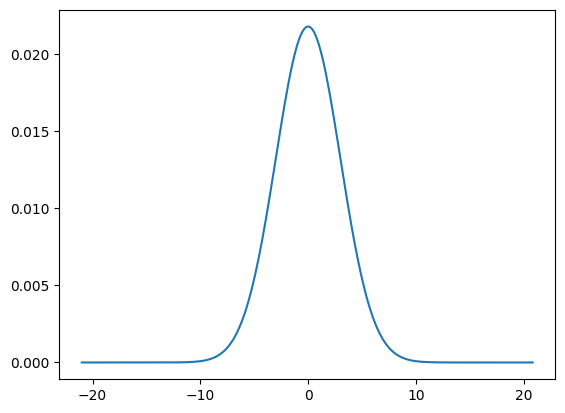

In [13]:
def test1d(m, σ, a=None, b=None):
    if b is None:
        b = 7*σ
    if a is None:
        a = -b
    J, h, E0, x, s = Gaussian2Ising(m, [[σ]], [a], [b])
    #
    # Construct the exponent
    E = np.sum(s * (J @ s), 0) + h @ s + E0
    #
    # Construct wavefunction
    p = np.exp(-E)
    print(f'Normalization: {np.sum(p)}')
    return p, x, s

aux_p, aux_x, aux_s = test1d(8, 3.)
#fig = plot_setup()
plt.plot(aux_x, aux_p)

file 4: (time evolution)

In [14]:
def mpoSup(n, **kwdargs):

    A = np.zeros((2,2,2,2))
    A[0,0,0,0] = 1.
    A[0,1,1,0] = 1.
    A[1,0,1,1] = 1.
    A[0,1,0,1] = 1.

    R = A[:,:,:,[1]]
    L = A[[0],:,:,:] # + A[[1],:,:,:]
    return MPO([L] + [A] * (n-2) + [R], **kwdargs)

def mpoSdown(n, **kwdargs):

    A = np.zeros((2,2,2,2))
    A[0,0,0,0] = 1.
    A[0,1,1,0] = 1.
    A[0,0,1,1] = 1.
    A[1,1,0,1] = 1.

    R = A[:,:,:,[1]]
    L = A[[0],:,:,:] # + A[[1],:,:,:]
    return MPO([L] + [A] * (n-2) + [R], **kwdargs)

def mpo_combined(n,a,b,c, **kwdargs):
    # returns a*Id + b*S^+ + c*S^- (in MPO form; N controls its shape)

    A = np.zeros((3,2,2,3))
    # Internal bond dimension 0 is nothing, 1 is add 1, 2 is subtract 1

    A[0,0,0,0] = 1.
    A[0,1,1,0] = 1.
    # Increase
    A[0,1,0,1] = 1.
    A[1,0,1,1] = 1.
    # Decrease
    A[2,1,0,2] = 1.
    A[0,0,1,2] = 1.

    R = a*A[:,:,:,[0]] + b*A[:,:,:,[1]] + c*A[:,:,:,[2]]
    L = A[[0],:,:,:] # + A[[1],:,:,:] + A[[2],:,:,:]
    return MPO([L] + [A] * (n-2) + [R], **kwdargs)

In [15]:
n = 10
print(mpoSup(n)._data)
a = mpoSup(n) #.tomatrix()
print(a._data)
'''
for i in range(n):
  print(a._data[i].shape)
  print(a._data[i].shape[0], a._data[i].shape[1], a._data[i].shape[2])
'''

[array([[[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [1., 0.]]]]), array([[[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [1., 0.]]],


       [[[0., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]]]), array([[[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [1., 0.]]],


       [[[0., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]]]), array([[[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [1., 0.]]],


       [[[0., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]]]), array([[[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [1., 0.]]],


       [[[0., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]]]), array([[[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [1., 0.]]],


       [[[0., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]]]), array([[[[1., 0.],
         [0., 0.]],

        [[0., 1.],
         [1., 0.]]],


       [[[0., 0

'\nfor i in range(n):\n  print(a._data[i].shape)\n  print(a._data[i].shape[0], a._data[i].shape[1], a._data[i].shape[2])\n'

In [16]:
print(mpoSdown(3).tomatrix())
mpoSup(3).tomatrix()

[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [17]:
mpo_combined(3, 5, 2, 4).tomatrix()

array([[5., 4., 0., 0., 0., 0., 0., 0.],
       [2., 5., 4., 0., 0., 0., 0., 0.],
       [0., 2., 5., 4., 0., 0., 0., 0.],
       [0., 0., 2., 5., 4., 0., 0., 0.],
       [0., 0., 0., 2., 5., 4., 0., 0.],
       [0., 0., 0., 0., 2., 5., 4., 0.],
       [0., 0., 0., 0., 0., 2., 5., 4.],
       [0., 0., 0., 0., 0., 0., 2., 5.]])

Check effect of ladder operators in matrix form on simple vector:

In [18]:
b = [1,2,3,4,5,6,7,8]
m = mpoSdown(3).tomatrix() # 3: b has 2^3 elements
c = m@b
print(c)
m = mpoSup(3).tomatrix()
c = m@b
print(c)

a=10
b2=2
c2=3
m = mpo_combined(3, a, b2, c2).tomatrix() # = aId + b*S^+ + c*S^-
c = m@b
print(c)

[2. 3. 4. 5. 6. 7. 8. 0.]
[0. 1. 2. 3. 4. 5. 6. 7.]
[ 16.  31.  46.  61.  76.  91. 106.  94.]


In [19]:
b = np.arange(16)
print(b)
m = mpoSdown(4).tomatrix()
c = m@b
print(c)
m = mpoSup(4).tomatrix()
c = m@b
print(c)

a=10
b2=2
c2=3
m = mpo_combined(4, a, b2, c2).tomatrix() # = aId + b*S^+ + c*S^-
c = m@b
print(c)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.  0.]
[ 0.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[  3.  16.  31.  46.  61.  76.  91. 106. 121. 136. 151. 166. 181. 196.
 211. 178.]


Check ladder operators in MPO form on simple MPS:

ψmps <__main__.CanonicalMPS object at 0x798bc7485d20>


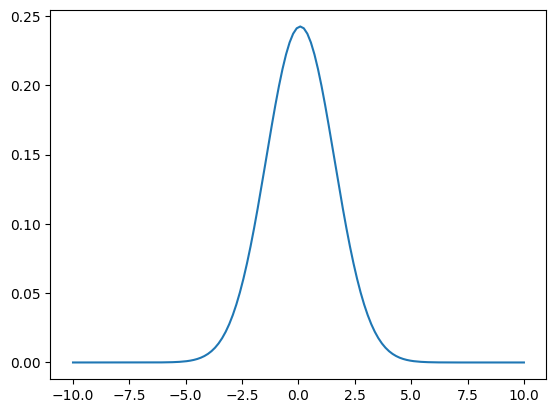

n1 0.991837199781314


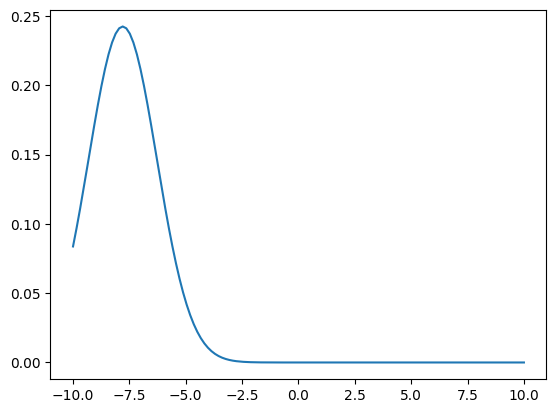

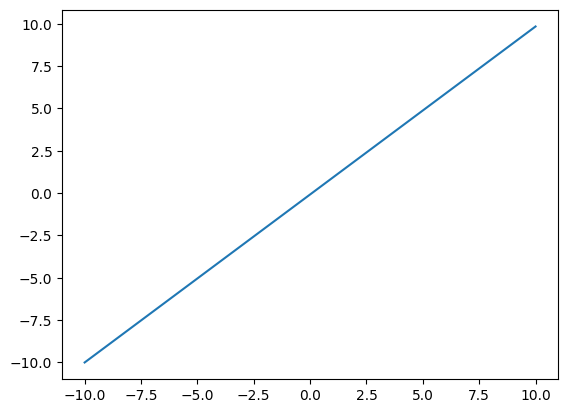

'\nψmps1 = MPS.fromvector(vect, (2,2,2,2,2,2,2)) ## becomes normalized. what should dimensions be?\nif (isinstance(ψmps1, MPS)): print("is mps")\nψ1 = ψmps1.tovector()\nplt.plot(np.linspace(a,b,len(ψ1)), ψ1)\nplt.show()\n\n\nψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)\nψ0 = ψmps0.tovector()\nplt.plot(np.linspace(a,b,len(ψ0)), ψ0)\nplt.show()\nprint(len(ψ0))\n\nψmps1 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)\nψmps0.__add__(ψmps1)\nψ1 = ψmps0.tovector()\nplt.plot(np.linspace(a,b,len(ψ1)), ψ1)\nplt.show()\nprint(len(ψ1))\n\nψmps0.__mul__(3)\nψ1 = ψmps0.tovector()\nplt.plot(np.linspace(a,b,len(ψ1)), ψ1)\nplt.show()\nprint(len(ψ1))\n\nif (isinstance(ψmps0, CanonicalMPS)): print("canonical")\nif (isinstance(ψmps0, MPS)): print("mps")\n'

In [20]:
a = -10.
b = 10.
N = 7
σ = 1.5

ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
ψ0 = ψmps0.tovector()
plt.plot(np.linspace(a,b,len(ψ0)), ψ0)
plt.show()

mpo1 = mpo_combined(N, 0., 0., 1., simplify=True) # apply S^- (ie p[x]->p[x-dx]) -> curve moves to the left, and 0s appear from the right
for i in range(50): ψmps0 = mpo1.apply(ψmps0)
ψ1 = ψmps0.tovector()
n1 = np.linalg.norm(ψ1)
print("n1", n1)
plt.plot(np.linspace(a,b,len(ψ1)), ψ1)
plt.show()

vect = []
for x in range(2**N): vect.append(a + x*(b-a)/(2**N))
plt.plot(np.linspace(a,b,len(vect)), vect)
plt.show()

'''
ψmps1 = MPS.fromvector(vect, (2,2,2,2,2,2,2)) ## becomes normalized. what should dimensions be?
if (isinstance(ψmps1, MPS)): print("is mps")
ψ1 = ψmps1.tovector()
plt.plot(np.linspace(a,b,len(ψ1)), ψ1)
plt.show()


ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
ψ0 = ψmps0.tovector()
plt.plot(np.linspace(a,b,len(ψ0)), ψ0)
plt.show()
print(len(ψ0))

ψmps1 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
ψmps0.__add__(ψmps1)
ψ1 = ψmps0.tovector()
plt.plot(np.linspace(a,b,len(ψ1)), ψ1)
plt.show()
print(len(ψ1))

ψmps0.__mul__(3)
ψ1 = ψmps0.tovector()
plt.plot(np.linspace(a,b,len(ψ1)), ψ1)
plt.show()
print(len(ψ1))

if (isinstance(ψmps0, CanonicalMPS)): print("canonical")
if (isinstance(ψmps0, MPS)): print("mps")
'''

In [21]:
def mpo_drift(n, δt, δx, μ, D, **kwdargs):
    Dx = D/δx**2
    μx = μ/(2*δx)
    a = 1 - 2*δt*Dx
    b = δt*(Dx-μx)
    c = δt*(Dx+μx)
    print(f'δx={δx}, δt={δt}, D={D}, μ={μ}')
    print(f'Coefficients: a={a}, b={b}, c={c}')
    print("mpodrif", n, a, b, c)
    return mpo_combined(n, a, b, c, **kwdargs) # = a*Id + b*S^+ + c*S^- (in MPO form; n controls its shape)

For making a video of time evolution of solution:

In [22]:
pip install matplotlib imageio

In [23]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
import os

def get_gif(ncurves, x1, x2, x3, x4, duration_t, bond1, bond2, bond3, bond4, namefile):
  filenames = []
  for i, y in enumerate(ψ):
      #if i==16: break
      plt.figure(figsize=(8, 6))

      plt.xlim(x1,x2)
      plt.ylim(x3,x4)

      plt.plot(x, mps_fcts[0][i], label=f'MPS {i}, X={bond1}', color='orange')
      if ncurves>=2: plt.plot(x, mps_fcts[1][i], label=f'MPS {i}, X={bond2}', color='red')
      if ncurves>=3: plt.plot(x, mps_fcts[2][i], label=f'MPS {i}, X={bond3}', color='pink')
      if ncurves>=4: plt.plot(x, mps_fcts[3][i], label=f'MPS {i}, X={bond4}', color='blue')
      plt.plot(x, ψ_r[i], label=f'Real {i}', color='green')
      plt.title('Evolution of Curves')
      plt.xlabel('x')
      plt.ylabel('P(x)')
      plt.legend()
      plt.grid(True)

      # Save each frame as a file
      filename = f'frame_{i}.png'
      plt.savefig(filename)
      plt.close()
      filenames.append(filename)

  # Create an animated gif
  with imageio.get_writer(namefile, mode='I', duration=duration_t) as writer:
      for filename in filenames:
          image = imageio.imread(filename)
          writer.append_data(image)

      # Remove files
      for filename in filenames:
          os.remove(filename)

  print("GIF created successfully!")

def get_gif2(ncurves, x1, x2, x3, x4, duration_t, bond1, bond2, bond3, bond4, namefile):
  filenames = []
  for i, y in enumerate(ψ):
      #if i==16: break
      plt.figure(figsize=(8, 6))

      plt.xlim(x1,x2)
      plt.ylim(x3,x4)

      plt.plot(x, mps_fcts[0][i], label=f'MPS {i}, X={bond1}', color='orange')
      if ncurves>=2: plt.plot(x, mps_fcts[1][i], label=f'MPS {i}, X={bond2}', color='red')
      if ncurves>=3: plt.plot(x, mps_fcts[2][i], label=f'MPS {i}, X={bond3}', color='pink')
      if ncurves>=4: plt.plot(x, mps_fcts[3][i], label=f'MPS {i}, X={bond4}', color='blue')
      plt.plot(x, ψ_r[i], label=f'1st order Standard {i}', color='green')
      plt.plot(x, ψ_r0[i], label=f'2nd order Standard {i}', color='black')
      plt.title('Evolution of Curves')
      plt.xlabel('x')
      plt.ylabel('P(x)')
      plt.legend()
      plt.grid(True)

      # Save each frame as a file
      filename = f'frame_{i}.png'
      plt.savefig(filename)
      plt.close()
      filenames.append(filename)

  # Create an animated gif
  with imageio.get_writer(namefile, mode='I', duration=duration_t) as writer:
      for filename in filenames:
          image = imageio.imread(filename)
          writer.append_data(image)

      # Remove files
      for filename in filenames:
          os.remove(filename)

  print("GIF created successfully!")

Make a comparison between MPS and real functions: compute supremum norm

In [24]:
# x: x-coordinates (has 2**N elements)
# mps_fcts[b][i][j]: b fctn (b-th bond) at time step i and at x-location j
# ψ_r: real evolution. ψ_r[i][j]: at time step i and at x-location j

'''
plots the evolution over time of the supremum error between each
function mps_fctns[b][i] (bond dim Xi) and ψ_r. plots all curves (number: ncurves) at the same time.
bonds b1,..,4.
'''
def errors_fctns(nfctns, mps_fcts, ψ_r, b1, b2, b3, b4):
  maxdifs = []
  for k in range(nfctns):
    difs = []
    ntests = len(mps_fcts[0]) # =len(times)
    for i in range(ntests):
      difs.append(max(abs(mps_fcts[k][i] - ψ_r[i]))) #maxdif between
    maxdifs.append(difs) #maxdifs[k]= max difs between mps[k] and real solution during interval times

  plt.plot(times, maxdifs[0], label=f'X={b1}', color='orange')
  if nfctns>=2: plt.plot(times, maxdifs[1], label=f'X={b2}', color='red')
  if nfctns>=3: plt.plot(times, maxdifs[2], label=f'X={b3}', color='pink')
  if nfctns>=4: plt.plot(times, maxdifs[3], label=f'X={b4}', color='blue')
  plt.legend()
  plt.xlabel("Time (s)")
  plt.ylabel("$||\\psi-\\phi||_\\infty$")
  plt.tight_layout()
  plt.show()
  return 0

def errors_fctns_data(nfctns, mps_fcts, ψ_r, b1, b2, b3, b4):
  maxdifs = []
  for k in range(nfctns):
    difs = []
    ntests = len(mps_fcts[0]) # =len(times)
    for i in range(ntests):
      difs.append(max(abs(mps_fcts[k][i] - ψ_r[i]))) #maxdif between
    maxdifs.append(difs) #maxdifs[k]= max difs between mps[k] and real solution during interval times

  ## create file maxdifs_b1.txt with (times, maxdifs[1]) for X=b1, in 2 columns:
  with open('maxdifs_b1.txt', 'w') as file:
    file.write('x\tf(x)\n')
    for time, maxdif in zip(times, maxdifs[0]):
        file.write(f'{time}\t{maxdif}\n')

  ## same with b2:
  with open('maxdifs_b2.txt', 'w') as file:
    file.write('x\tf(x)\n')
    for time, maxdif in zip(times, maxdifs[1]):
        file.write(f'{time}\t{maxdif}\n')

  ## with b3:
  with open('maxdifs_b3.txt', 'w') as file:
    file.write('x\tf(x)\n')
    for time, maxdif in zip(times, maxdifs[2]):
        file.write(f'{time}\t{maxdif}\n')

  ## with b4:
  with open('maxdifs_b4.txt', 'w') as file:
    file.write('x\tf(x)\n')
    for time, maxdif in zip(times, maxdifs[3]):
        file.write(f'{time}\t{maxdif}\n')

  return 0

# Added functions: for state information

In [25]:
mps_fcts = []
real_fcts = []
sizes_mpo = []
b1 = 8
b2 = 16
b3 = 24
b4 = 32
N = 10
T=3.
steps=30

for i in range(1):
  if i==0: mbd = 32
  if i==1: mbd = b2
  if i==2: mbd = b3
  if i==3: mbd = b4
  mdb2 = mbd
  σ=1.0
  b=10.
  a=-b
  μ=3.0
  D=1.0
  npars = []

  δx = (b-a)/2**N
  times = np.linspace(0, T, steps)
  δt = times[1]
  ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
  ψ0 = ψmps0.tovector() #-> vector of size 2^N
  x = np.linspace(a, b, 2**N)
  # get 1+dt/2*G:
  mpo1 = mpo_drift(N, 0.5*δt, δx, μ, D, simplify=True) #changed simplify=False. MPO object, but corresponds to a time-evolution operator
  # get 1-dt/2*G:
  mpo2 = mpo_drift(N, -0.5*δt, δx, μ, D, simplify=True) #changed simplify=False
  # convert both into matrices:
  op1 = sp.csr_matrix(mpo1.tomatrix()) # becomes a 1024x1024 matrix, and sp.csr_matrix compresses the matrix into a Compressed Sparse Row (CSR) format
  op2 = sp.csr_matrix(mpo2.tomatrix()) # same
  # express initial MPS as 1D vector:
  ψ = [ψ0] #[1024-length vector]
  ψ_r = [ψ0]
  print(f'int(ψ)={np.sum(ψ0)}, |ψ|={np.linalg.norm(ψ0)}') #state at t=0
  for t in times[1:]:
      print("t: ", t)
      pars = 0
      for i in range(10):
        pars += ψmps0._data[i].shape[0] * ψmps0._data[i].shape[1] * ψmps0._data[i].shape[2]
      npars.append(pars)

      # for i in range(10): print(ψmps0._data[i].shape)

      ψ0 = sp.linalg.spsolve(op2, op1 @ ψ0)
      ψ_r.append(ψ0)
      n0 = np.linalg.norm(ψ0)
      ψmps0, err = cgs(mpo2, mpo1.apply(ψmps0))
      ψ1 = ψmps0.tovector()
      n1 = np.linalg.norm(ψ1)
      sc = 1 - np.vdot(ψ1, ψ0)/(n1*n0)
      print(f'int(ψ)={np.sum(ψ0):5f}, |ψ|={n0:5f}, |ψmps|={n1:5f}, sc={sc:5g}, err={err:5g}')
      ψ.append(ψ1)
  mps_fcts.append(ψ)
  real_fcts.append(ψ_r)

ψmps <__main__.CanonicalMPS object at 0x798bc319a350>
δx=0.01953125, δt=0.05172413793103448, D=1.0, μ=3.0
Coefficients: a=-270.1834482758621, b=131.61931034482757, c=139.56413793103448
mpodrif 10 -270.1834482758621 131.61931034482757 139.56413793103448
δx=0.01953125, δt=-0.05172413793103448, D=1.0, μ=3.0
Coefficients: a=272.1834482758621, b=-131.61931034482757, c=-139.56413793103448
mpodrif 10 272.1834482758621 -131.61931034482757 -139.56413793103448
int(ψ)=13.472166254653038, |ψ|=1.0
t:  0.10344827586206896
int(ψ)=13.472166, |ψ|=0.955194, |ψmps|=0.955791, sc=3.46827e-06, err=0.000561081
t:  0.20689655172413793
int(ψ)=13.472166, |ψ|=0.918668, |ψmps|=0.914700, sc=8.60977e-06, err=0.00355064
t:  0.3103448275862069


KeyboardInterrupt: 

For getting all the parameters used in the MPOs and in the matrices:

In [ ]:
a = mpo1._data # __format__ __len__ __repr__ __sizeof__ _data dimensions max_bond_dimension size
b = mpo2._data
#print(np.array(b).shape)
tot = 0
tot2 = 0
for i in range(10):
  tot2 += b[i].shape[0] * b[i].shape[1] * b[i].shape[2] * b[i].shape[3]
  tot += a[i].shape[0] * a[i].shape[1] * a[i].shape[2] * a[i].shape[3]
  print(np.array(b[i]).shape)
  #print(a[i].shape)
print(tot, tot2, tot+tot2)
print(op1.size, op2.size, op1.size+op2.size) #1024x1024 but its size is 3070 (sparse matrix -> not keep all its values)

In [ ]:
print(op1)

In [ ]:
pars = 0
for i in range(10):
  print(ψmps0._data[i].shape)
  pars += ψmps0._data[i].shape[0] * ψmps0._data[i].shape[1] * ψmps0._data[i].shape[2]
print("npars", pars)
print("dim", ψmps0.dimension)
print(ψmps0.entanglement_entropyAtCenter)
print(ψmps0.max_bond_dimension)
print(ψmps0.size)
print(ψmps0.tovector)

'''
dimensions of ψmps0:
(1, 2, 2)
(2, 2, 4)
(4, 2, 5)
(5, 2, 8)
(8, 2, 7) (ie 8 groups of pairs of 7 elemements: [has 8 of: [[1,2,3,4,5,6,7],[1,2,3,4,5,6,7]]])
(7, 2, 6)
(6, 2, 5)
(5, 2, 4)
(4, 2, 2)
(2, 2, 1)
-> initially is described by 456 values (instead of 1024 for the total vector)

later in time-evolution:
(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 16)
(16, 2, 29)
(29, 2, 16)
(16, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)

later:
(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 16)
(16, 2, 31)
(31, 2, 16)
(16, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)

-> can do tensor multiplication of all of these tensors (internal dimensions match) to get a scalar value
-> index of the middle (dim=2 all the time) correspond to the physical index
-> ψmps0[0101011011] corresponds to x = s=0101011011 in binary (guessed)
ie tensor prod but with these indices fixed, so have: (1,s0,i) * (i, s1, j) * .. * (k, s_n, 1) = (1,1) tensor = scalar value)
-> looks like larger bond dimension is 8 (?)
-> how to control bond dimension?
'''

Show number of parameters used in QI and SC methods, for different mbds and different N's:

In [ ]:
N=14
mbd=24
for mbd in [8,16,24,32]:
  print("mbd:", mbd)
  for N in [7,8,9,10,11,12,13,14,15,16]:

    #sizes mps, mpo:
    smps = (N-2)*2*mbd**2 + 2*2*mbd # in the worst case
    smpo = 2*( (N-2)*2*2*mbd**2 + 2* 2*2*mbd ) # but use 2 mpos (so also 2 matrices, so multiply by 2)

    #sizes vector, matrix:
    sv = 2**N
    sm = (2**N)**2 * 2 # 2 matrices

    print(N, smps, smpo, sv, sm)

#print(smps, 2**N)
#print(smpo * 2, (2**N)*3)

In [ ]:
mps_fcts = []
real_fcts = []
sizes_mpo = []
b1 = 8
b2 = 16
b3 = 24
b4 = 32
N = 10
T=3.
steps=30

for i in range(1):
  if i==0: mbd = b1
  if i==1: mbd = b2
  if i==2: mbd = b3
  if i==3: mbd = b4
  mdb2 = mbd
  σ=1.0
  b=10.
  a=-b
  μ=3.0
  D=1.0
  v=2.
  npars = []

  δx = (b-a)/2**N
  times = np.linspace(0, T, steps)
  δt = times[1]
  ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
  ψ0 = ψmps0.tovector() #-> vector of size 2^N
  x = np.linspace(a, b, 2**N)
  mpo1 = mpo_combined(N, 1-v*δt/(δx**2), v*δt/(2*δx**2), v*δt/(2*δx**2), simplify=True) #changed simplify=False. MPO object, but corresponds to a time-evolution operator
  mpo2 = mpo_combined(N, 1+v*δt/(δx**2), -v*δt/(2*δx**2), -v*δt/(2*δx**2), simplify=True)
  op1 = sp.csr_matrix(mpo1.tomatrix()) # becomes a 1024x1024 matrix, and sp.csr_matrix compresses the matrix into a Compressed Sparse Row (CSR) format
  op2 = sp.csr_matrix(mpo2.tomatrix())



In [ ]:
print()

# Experiments 1.1: Fokker-Planck equation

In [ ]:
mps_fcts = []
real_fcts = []
sizes_mpo = []
b1 = 8
b2 = 16
b3 = 24
b4 = 32
N = 14
T=3.
steps=30

for i in range(4):
  if i==0: mbd = b1
  if i==1: mbd = b2
  if i==2: mbd = b3
  if i==3: mbd = b4
  mdb2 = mbd
  σ=1.0
  b=10.
  a=-b
  μ=3.0
  D=1.0
  npars = []

  δx = (b-a)/2**N
  times = np.linspace(0, T, steps)
  δt = times[1]
  ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
  ψ0 = ψmps0.tovector() #-> vector of size 2^N
  x = np.linspace(a, b, 2**N)
  # get 1+dt/2*G:
  mpo1 = mpo_drift(N, 0.5*δt, δx, μ, D, simplify=True) #changed simplify=False. MPO object, but corresponds to a time-evolution operator
  # get 1-dt/2*G:
  mpo2 = mpo_drift(N, -0.5*δt, δx, μ, D, simplify=True) #changed simplify=False
  # convert both into matrices:
  op1 = sp.csr_matrix(mpo1.tomatrix()) # becomes a 1024x1024 matrix, and sp.csr_matrix compresses the matrix into a Compressed Sparse Row (CSR) format
  op2 = sp.csr_matrix(mpo2.tomatrix()) # same
  # express initial MPS as 1D vector:
  ψ = [ψ0] #[1024-length vector]
  ψ_r = [ψ0]
  print(f'int(ψ)={np.sum(ψ0)}, |ψ|={np.linalg.norm(ψ0)}') #state at t=0
  for t in times[1:]:
      print("t: ", t)
      pars = 0
      for i in range(10):
        pars += ψmps0._data[i].shape[0] * ψmps0._data[i].shape[1] * ψmps0._data[i].shape[2]
      npars.append(pars)


      # for i in range(10): print(ψmps0._data[i].shape)

      ψ0 = sp.linalg.spsolve(op2, op1 @ ψ0)
      ψ_r.append(ψ0)
      n0 = np.linalg.norm(ψ0)
      ψmps0, err = cgs(mpo2, mpo1.apply(ψmps0))
      ψ1 = ψmps0.tovector()
      n1 = np.linalg.norm(ψ1)
      sc = 1 - np.vdot(ψ1, ψ0)/(n1*n0)
      print(f'int(ψ)={np.sum(ψ0):5f}, |ψ|={n0:5f}, |ψmps|={n1:5f}, sc={sc:5g}, err={err:5g}')
      ψ.append(ψ1)
  mps_fcts.append(ψ)
  real_fcts.append(ψ_r)

# 4 curves, 5.0 seconds, bonds1,2,3,4:
get_gif(4, a, b, -0.05, 0.1, 10.0, 8, 16, 24, 32, 'evolutions.gif')
# evolution of errors over time:
errors_fctns(4, mps_fcts, ψ_r, b1, b2, b3, b4)

For getting the data files for making the plots with gnuplot:

In [ ]:
errors_fctns_data(4, mps_fcts, ψ_r, b1, b2, b3, b4)

In [ ]:
get_gif(4, a, b, -0.05, 0.1, 30.0, 8, 16, 24, 32, 'evolutions.gif')
errors_fctns(4, mps_fcts, ψ_r, b1, b2, b3, b4)

Computation time of each method (run for different values of mbd, eg 8, 16, 24, 32)

In [ ]:
import time
#pars:
for mbd in [8, 16, 24, 32]:
  #mbd = 8
  mdb2 = mbd
  T=1.
  steps=10
  #other pars:
  σ=1.0
  b=10.
  a=-b
  μ=3.0
  D=1.0

  times_c=[]
  times_q=[]
  for i in range(8):
    N = 7 +i

    ## get MPOs:
    δx = (b-a)/2**N
    times = np.linspace(0, T, steps)
    δt = times[1]
    ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
    ψ0 = ψmps0.tovector() #-> vector of size 2^N
    x = np.linspace(a, b, 2**N)
    # get 1+dt/2*G:
    mpo1 = mpo_drift(N, 0.5*δt, δx, μ, D, simplify=True) #changed simplify=False. MPO object, but corresponds to a time-evolution operator
    # get 1-dt/2*G:
    mpo2 = mpo_drift(N, -0.5*δt, δx, μ, D, simplify=True) #changed simplify=False

    ## Classical:
    op1 = sp.csr_matrix(mpo1.tomatrix()) # becomes a 1024x1024 matrix, and sp.csr_matrix compresses the matrix into a Compressed Sparse Row (CSR) format
    op2 = sp.csr_matrix(mpo2.tomatrix()) # same
    # express initial MPS as 1D vector:
    ψ = [ψ0] #[1024-length vector]
    ψ_r = [ψ0]
    print(f'int(ψ)={np.sum(ψ0)}, |ψ|={np.linalg.norm(ψ0)}') #state at t=0
    start_time = time.time()
    for t in times[1:]:
        ψ0 = sp.linalg.spsolve(op2, op1 @ ψ0)
        ψ_r.append(ψ0)
    elapsed_time = time.time() - start_time
    print("N=", N, "Elapsed time 1: ", elapsed_time)
    times_c.append(elapsed_time)

    ## with MPS:
    start_time = time.time()
    for t in times[1:]:
        ψmps0, err = cgs(mpo2, mpo1.apply(ψmps0))
        ψ1 = ψmps0.tovector()
        ψ.append(ψ1)
    elapsed_time = time.time() - start_time
    print("N=", N, "Elapsed time 2: ", elapsed_time)
    times_q.append(elapsed_time)

  print("done mbd=", mbd)
  #shows times classical and QI for N=7,8,..,14 (and the mbd used)
  print("times_c:", times_c)
  print("times_q:", times_q)

In [ ]:
## if only two times:

plt.plot([8,10,12,14], times_c, label='Standard approach')
plt.plot([8,10,12,14], times_q, label='MPS based approach')
plt.xlabel("N")
plt.ylabel("Time (s)")
plt.legend()
plt.plot()

plot evolution of time for 10 steps as a function of N, for different mbds:

In [ ]:
# mbd=24:
times_c24 = [0.0071258544921875, 0.0049364566802978516, 0.012398242950439453, 0.13854289054870605]
times_q24 = [51.00358033180237, 95.2507176399231, 183.11718702316284, 268.70102071762085]

for i in range(4): times_c[i] *= 1000
plt.plot([8,10,12,14], times_c, label='Standard')
plt.plot([8,10,12,14], times_q8, label='MPS based, $\chi_{\mathrm{max}} = 8$')
plt.plot([8,10,12,14], times_q16, label='MPS based, $\chi_{\mathrm{max}} = 16$')
plt.plot([8,10,12,14], times_q24, label='MPS based, $\chi_{\mathrm{max}} = 24$')
plt.plot([8,10,12,14], times_q32, label='MPS based, $\chi_{\mathrm{max}} = 32$')
plt.xlabel("N")
plt.ylabel("Time (s)")
plt.legend()
plt.tight_layout()
plt.plot()

# Experiments 1.2: F-P with higher precision dp/dx:

In [ ]:
## use: mpo_combined(n,a,b,c, **kwdargs): returns a*Id + b*S^+ + c*S^- (MPO)

## returns MPO 1 + δt/2 * G2, where G2 is for higher order approx of d/dx derivatives
def mpo_drift2(n, δt, δx, μ, D, **kwdargs):
    ## get Id, S^+ and S^-:
    id = mpo_combined(n, 1., 0, 0, **kwdargs)
    up = mpo_combined(n, 0, 1., 0, **kwdargs) # = a*Id + b*S^+ + c*S^- (in MPO form; n controls its shape)
    down = mpo_combined(n, 0, 0, 1., **kwdargs)
    ## get (S^+)**2:
    up_sqr = MPOList(mpos=[up, up]) ## = up@up = (S^+)**2 (in MPO form) -> print(up2.tomatrix())
    down_sqr = MPOList(mpos=[down, down])
    ## put all together in a single MPO:
    c_id = 1 - 2.5*D/(δx**2) * δt/2
    c_down = (μ*2/(3*δx) + D*4/(3*δx**2)) * δt/2
    c_up = (-μ*2/(3*δx) + 4*D/(3*δx**2)) * δt/2
    c_down_sqr = (-μ/(6*δx) - D/(12*δx**2)) * δt/2
    c_up_sqr = (μ/(12*δx) - D/(12*δx**2)) * δt/2
    ## OP2 = 1 + δt/2 * G2
    return MPOSum(mpos=[id, down, down_sqr, up, up_sqr], weights=[c_id, c_down, c_down_sqr, c_up, c_up_sqr])

op = mpo_drift2(3, 0.1, 0.02, 1.0, 0.5, simplify=True)
print(op.tomatrix())

In [ ]:
mps_fcts = []
real_fcts = []
sizes_mpo = []
b1 = 8
b2 = 16
b3 = 24
b4 = 32
N = 10
T=3.
steps=30

for i in range(1):
  if i==0: mbd = b3
  if i==1: mbd = b2
  if i==2: mbd = b3
  if i==3: mbd = b4
  mdb2 = mbd
  σ=1.0
  b=10.
  a=-b
  μ=3.0
  D=1.0
  npars = []

  δx = (b-a)/2**N
  times = np.linspace(0, T, steps)
  δt = times[1]
  ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
  ψ0 = ψmps0.tovector() #-> vector of size 2^N
  ψ00 = ψ0
  x = np.linspace(a, b, 2**N)

  # get operators using 1st order approx of d/dx:
  mpo10 = mpo_drift(N, 0.5*δt, δx, μ, D, simplify=True)
  mpo20 = mpo_drift(N, -0.5*δt, δx, μ, D, simplify=True)
  op10 = sp.csr_matrix(mpo10.tomatrix())
  op20 = sp.csr_matrix(mpo20.tomatrix())

  # get operators using 2nd order approx of d/dx:
  # get 1+dt/2*G2: (the *1/2 is in the function)
  mpo1 = mpo_drift2(N, δt, δx, μ, D, simplify=True)
  # get 1-dt/2*G2:
  mpo2 = mpo_drift2(N, -δt, δx, μ, D, simplify=True)
  op1 = sp.csr_matrix(mpo1.tomatrix())
  op2 = sp.csr_matrix(mpo2.tomatrix())
  # express initial MPS as 1D vector:
  ψ = [ψ0] #[1024-length vector]
  ψ_r = [ψ0]
  ψ_r0 = [ψ0]

  print(f'int(ψ)={np.sum(ψ0)}, |ψ|={np.linalg.norm(ψ0)}') #state at t=0
  for t in times[1:]:
      print("t: ", t)
      pars = 0
      for i in range(10):
        pars += ψmps0._data[i].shape[0] * ψmps0._data[i].shape[1] * ψmps0._data[i].shape[2]
      npars.append(pars)

      # for i in range(10): print(ψmps0._data[i].shape)

      # with 1st order approx:
      ψ00 = sp.linalg.spsolve(op20, op10 @ ψ00)
      ψ_r0.append(ψ00)

      ψ0 = sp.linalg.spsolve(op2, op1 @ ψ0)
      ψ_r.append(ψ0)
      n0 = np.linalg.norm(ψ0)
      ψmps0, err = cgs(mpo2, mpo1.apply(ψmps0))
      ψ1 = ψmps0.tovector()
      n1 = np.linalg.norm(ψ1)
      sc = 1 - np.vdot(ψ1, ψ0)/(n1*n0)
      print(f'int(ψ)={np.sum(ψ0):5f}, |ψ|={n0:5f}, |ψmps|={n1:5f}, sc={sc:5g}, err={err:5g}')
      ψ.append(ψ1)
  mps_fcts.append(ψ)
  real_fcts.append(ψ_r)

# 4 curves, 5.0 seconds, bonds1,2,3,4:
get_gif2(1, a, b, -0.05, 0.1, 10.0, 24, 16, 24, 32, 'evolutions.gif')
# evolution of errors over time:
errors_fctns(1, mps_fcts, ψ_r, b3, b2, b3, b4)

In [ ]:
maxdifs = []
for k in range(1):
  difs = []
  nt = len(mps_fcts[0]) # =len(times)
  for i in range(nt):
    difs.append(max(abs(mps_fcts[k][i] - ψ_r[i]))) # max difference at time-step i between MPS and ψ_r (ie over all x values)
  maxdifs.append(difs) #maxdifs[k]= max difs between mps[k] and real solution during interval times

## create file maxdifs_b1.txt with (times, maxdifs[1]) for X=b1, in 2 columns:
with open('maxdifs_b1.txt', 'w') as file:
  file.write('x\tf(x)\n')
  for time, maxdif in zip(times, maxdifs[0]):
      file.write(f'{time}\t{maxdif}\n')

# Experiments 2: Diffusion equation

In [ ]:
mps_fcts = []
real_fcts = []
sizes_mpo = []
b1 = 8
b2 = 16
b3 = 24
b4 = 32
N = 14
T=3.
steps=30

for i in range(4):
  if i==0: mbd = b1
  if i==1: mbd = b2
  if i==2: mbd = b3
  if i==3: mbd = b4
  mdb2 = mbd
  σ=1.0
  b=10.
  a=-b
  μ=3.0
  D=1.0
  v=2.
  npars = []

  δx = (b-a)/2**N
  times = np.linspace(0, T, steps)
  δt = times[1]
  ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
  ψ0 = ψmps0.tovector() #-> vector of size 2^N
  x = np.linspace(a, b, 2**N)
  mpo1 = mpo_combined(N, 1-v*δt/(δx**2), v*δt/(2*δx**2), v*δt/(2*δx**2), simplify=True) #changed simplify=False. MPO object, but corresponds to a time-evolution operator
  mpo2 = mpo_combined(N, 1+v*δt/(δx**2), -v*δt/(2*δx**2), -v*δt/(2*δx**2), simplify=True)
  op1 = sp.csr_matrix(mpo1.tomatrix()) # becomes a 1024x1024 matrix, and sp.csr_matrix compresses the matrix into a Compressed Sparse Row (CSR) format
  op2 = sp.csr_matrix(mpo2.tomatrix())
  # express initial MPS as 1D vector:
  ψ = [ψ0] #[1024-length vector]
  ψ_r = [ψ0]
  print(f'int(ψ)={np.sum(ψ0)}, |ψ|={np.linalg.norm(ψ0)}') #state at t=0
  for t in times[1:]:
      print("t: ", t)
      pars = 0
      for i in range(10):
        pars += ψmps0._data[i].shape[0] * ψmps0._data[i].shape[1] * ψmps0._data[i].shape[2]
      npars.append(pars)

      # for i in range(10): print(ψmps0._data[i].shape)

      ψ0 = sp.linalg.spsolve(op2, op1 @ ψ0)
      ψ_r.append(ψ0)
      n0 = np.linalg.norm(ψ0)
      ψmps0, err = cgs(mpo2, mpo1.apply(ψmps0))
      ψ1 = ψmps0.tovector()
      n1 = np.linalg.norm(ψ1)
      sc = 1 - np.vdot(ψ1, ψ0)/(n1*n0)
      print(f'int(ψ)={np.sum(ψ0):5f}, |ψ|={n0:5f}, |ψmps|={n1:5f}, sc={sc:5g}, err={err:5g}')
      ψ.append(ψ1)
  mps_fcts.append(ψ)
  real_fcts.append(ψ_r)

# 4 curves, 5.0 seconds, bonds1,2,3,4:
get_gif(4, a, b, -0.05, 0.1, 10.0, 8, 16, 24, 32, 'evolutions.gif')
# evolution of errors over time:
errors_fctns(4, mps_fcts, ψ_r, b1, b2, b3, b4)
# put data in files:
errors_fctns_data(4, mps_fcts, ψ_r, b1, b2, b3, b4)

In [ ]:
get_gif(4, a, b, -0.05, 0.1, 500.0, 8, 16, 24, 32, 'evolutions.gif')
errors_fctns(4, mps_fcts, ψ_r, b1, b2, b3, b4)

In [ ]:
#print(mps_fcts[0])
n=(2**18)**2
print(n)
x=np.linspace(0,5,7)
print(x)
x = np.linspace(0,100,n)

In [ ]:
get_gif(4, a, b, -0.05, 0.1, 120.0, 8, 16, 24, 32, 'evolutions.gif')

Computation times:

In [26]:
import time
#pars:
for mbd in [8, 16, 24, 32]:
  mdb2 = mbd
  T=1.
  steps=10
  #other pars:
  σ=1.0
  b=10.
  a=-b
  μ=3.0
  D=1.0

  times_c=[]
  times_q=[]
  for i in range(8):
    N = i + 7 #8 +i*2

    ## get MPOs:
    δx = (b-a)/2**N
    times = np.linspace(0, T, steps)
    δt = times[1]
    ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
    ψ0 = ψmps0.tovector() #-> vector of size 2^N
    x = np.linspace(a, b, 2**N)
    # get 1+dt/2*G:
    mpo1 = mpo_drift(N, 0.5*δt, δx, μ, D, simplify=True) #changed simplify=False. MPO object, but corresponds to a time-evolution operator
    # get 1-dt/2*G:
    mpo2 = mpo_drift(N, -0.5*δt, δx, μ, D, simplify=True) #changed simplify=False

    ## Classical:
    op1 = sp.csr_matrix(mpo1.tomatrix()) # becomes a 1024x1024 matrix, and sp.csr_matrix compresses the matrix into a Compressed Sparse Row (CSR) format
    op2 = sp.csr_matrix(mpo2.tomatrix()) # same
    # express initial MPS as 1D vector:
    ψ = [ψ0] #[1024-length vector]
    ψ_r = [ψ0]
    print(f'int(ψ)={np.sum(ψ0)}, |ψ|={np.linalg.norm(ψ0)}') #state at t=0
    start_time = time.time()
    for t in times[1:]:
        ψ0 = sp.linalg.spsolve(op2, op1 @ ψ0)
        ψ_r.append(ψ0)
    elapsed_time = time.time() - start_time
    print("N=", N, "Elapsed time 1: ", elapsed_time)
    times_c.append(elapsed_time)

    ## with MPS:
    start_time = time.time()
    for t in times[1:]:
        ψmps0, err = cgs(mpo2, mpo1.apply(ψmps0))
        ψ1 = ψmps0.tovector()
        ψ.append(ψ1)
    elapsed_time = time.time() - start_time
    print("N=", N, "Elapsed time 2: ", elapsed_time)
    times_q.append(elapsed_time)

  print("done mbd=", mbd)
  #shows times classical and QI for N=7,8,..,14 (and the mbd used)
  print("times_c:", times_c)
  print("times_q:", times_q)

ψmps <__main__.CanonicalMPS object at 0x798bc31a2bc0>
δx=0.15625, δt=0.05555555555555555, D=1.0, μ=3.0
Coefficients: a=-3.551111111111111, b=1.7422222222222221, c=2.8088888888888888
mpodrif 7 -3.551111111111111 1.7422222222222221 2.8088888888888888
δx=0.15625, δt=-0.05555555555555555, D=1.0, μ=3.0
Coefficients: a=5.551111111111111, b=-1.7422222222222221, c=-2.8088888888888888
mpodrif 7 5.551111111111111 -1.7422222222222221 -2.8088888888888888
int(ψ)=4.763130057218616, |ψ|=1.0
N= 7 Elapsed time 1:  0.0020372867584228516
N= 7 Elapsed time 2:  80.4684009552002
ψmps <__main__.CanonicalMPS object at 0x798bc31a0640>
δx=0.078125, δt=0.05555555555555555, D=1.0, μ=3.0
Coefficients: a=-17.204444444444444, b=8.035555555555556, c=10.168888888888889
mpodrif 8 -17.204444444444444 8.035555555555556 10.168888888888889
δx=0.078125, δt=-0.05555555555555555, D=1.0, μ=3.0
Coefficients: a=19.204444444444444, b=-8.035555555555556, c=-10.168888888888889
mpodrif 8 19.204444444444444 -8.035555555555556 -10.168

Plot evolution of computation times:

In [ ]:
# mbd=24:
times_c24 = # copy the 4 times
times_q24 = # copy the 4 times

for i in range(4): times_c[i] *= 1000
plt.plot([8,10,12,14], times_c, label='Standard')
plt.plot([8,10,12,14], times_q8, label='MPS based, $\chi_{\mathrm{max}} = 8$')
plt.plot([8,10,12,14], times_q16, label='MPS based, $\chi_{\mathrm{max}} = 16$')
plt.plot([8,10,12,14], times_q24, label='MPS based, $\chi_{\mathrm{max}} = 24$')
plt.plot([8,10,12,14], times_q32, label='MPS based, $\chi_{\mathrm{max}} = 32$')
plt.xlabel("N")
plt.ylabel("Time (s)")
plt.legend()
plt.tight_layout()
plt.plot()

# Experiments 2-2: Diffusion equation

In [ ]:
mps_fcts = []
real_fcts = []
sizes_mpo = []

for i in range(3):
  if i==0: mbd = 8
  if i==1: mbd = 20
  if i==2: mbd = 32
  mdb2 = mbd

  N=8
  σ=1.0
  v=2.
  T=3.
  steps=50
  b=10.
  a=-b
  npars = []

  δx = (b-a)/2**N
  times = np.linspace(0, T, steps)
  δt = times[1]
  ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
  ψ0 = ψmps0.tovector() #-> vector of size 2^N
  x = np.linspace(a, b, 2**N)
  mpo1 = mpo_combined(N, 1-v*δt/(δx**2), v*δt/(2*δx**2), v*δt/(2*δx**2), simplify=True) #changed simplify=False. MPO object, but corresponds to a time-evolution operator
  mpo2 = mpo_combined(N, 1+v*δt/(δx**2), -v*δt/(2*δx**2), -v*δt/(2*δx**2), simplify=True)
  op1 = sp.csr_matrix(mpo1.tomatrix()) # becomes a 1024x1024 matrix, and sp.csr_matrix compresses the matrix into a Compressed Sparse Row (CSR) format
  op2 = sp.csr_matrix(mpo2.tomatrix())
  # express initial MPS as 1D vector:
  ψ = [ψ0] #[1024-length vector]
  ψ_r = [ψ0]
  print(f'int(ψ)={np.sum(ψ0)}, |ψ|={np.linalg.norm(ψ0)}') #state at t=0
  for t in times[1:]:
      pars = 0
      for i in range(N):
        pars += ψmps0._data[i].shape[0] * ψmps0._data[i].shape[1] * ψmps0._data[i].shape[2]
      npars.append(pars)
      # for i in range(10): print(ψmps0._data[i].shape)
      ψ0 = sp.linalg.spsolve(op2, op1 @ ψ0)
      ψ_r.append(ψ0)
      n0 = np.linalg.norm(ψ0)
      ψmps0, err = cgs(mpo2, mpo1.apply(ψmps0))
      ψ1 = ψmps0.tovector()
      n1 = np.linalg.norm(ψ1)
      sc = 1 - np.vdot(ψ1, ψ0)/(n1*n0)
      print(f'int(ψ)={np.sum(ψ0):5f}, |ψ|={n0:5f}, |ψmps|={n1:5f}, sc={sc:5g}, err={err:5g}')
      ψ.append(ψ1)
  mps_fcts.append(ψ)
  real_fcts.append(ψ_r)

# Experiments 3: Burgers equation

In [ ]:
import scipy.sparse as sp
import os.path

mps_fcts = []
real_fcts = []
sizes_mpo = []

for i in range(2):
  if i==0: mbd = 8
  if i==1: mbd = 8
  mdb2 = mbd

  N=10
  σ=1.0
  T=0.2
  steps=50
  b=10.
  a=-b

  #pars of eq:
  v=0.1
  npars = []

  δx = (b-a)/2**N
  times = np.linspace(0, T, steps)
  δt = times[1]
  ψmps0 = GaussianMPS(N, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
  ψ0 = ψmps0.tovector() #-> vector of size 2^N
  x = np.linspace(a, b, 2**N)

  ## here put the mpos of Burgers equation:
  mpo1 = mpo_combined(N, 1.0, v*δt/(2*δx), -v*δt/(2*δx), simplify=True) # MPO object, but corresponds to a time-evolution operator
  mpo2 = mpo_combined(N, 0, -δt/(δx**2), 0, simplify=True) # S^+
  mpo3 = mpo_combined(N, 0, 0, -δt/(δx**2), simplify=True) # S^-
  c_squared = 2*δt/(δx**2)

  op1 = sp.csr_matrix(mpo1.tomatrix()) # becomes a 1024x1024 matrix, and sp.csr_matrix compresses the matrix into a Compressed Sparse Row (CSR) format
  op2 = sp.csr_matrix(mpo2.tomatrix())
  op3 = sp.csr_matrix(mpo3.tomatrix())

  ψ = [ψ0] #[1024-length vector]
  ψ_r = [ψ0]
  print(f'int(ψ)={np.sum(ψ0)}, |ψ|={np.linalg.norm(ψ0)}') #state at t=0
  for t in times[1:]:

      pars = 0
      for i in range(10):
        pars += ψmps0._data[i].shape[0] * ψmps0._data[i].shape[1] * ψmps0._data[i].shape[2]
      npars.append(pars)

      # for i in range(10): print(ψmps0._data[i].shape)

      # ψ0 = sp.linalg.spsolve(op2, op1 @ ψ0)
      ψ0squared = []
      for val in ψ0: ψ0squared.append(val**2 * c_squared)
      ψ0 = op1 @ ψ0 + op2 @ ψ0 + op3 @ ψ0 + ψ0squared
      ψ_r.append(ψ0)
      '''
      n0 = np.linalg.norm(ψ0)
      ψmps1 = mpo1.apply(ψmps0)
      ψmps0 = ψmps1 + # add the 3 other terms
      ψ1 = ψmps0.tovector()
      '''
      ψ1 = ψ0
      n1 = np.linalg.norm(ψ1)
      sc = 1 - np.vdot(ψ1, ψ0)/(n1*n0)
      #print(f'int(ψ)={np.sum(ψ0):5f}, |ψ|={n0:5f}, |ψmps|={n1:5f}, sc={sc:5g}, err={err:5g}')
      ψ.append(ψ1)
  mps_fcts.append(ψ)
  real_fcts.append(ψ_r)

# Code for Quantum Fourier Transform with MPS

 need 'from mps.qft import qft_mpo, qft_flip, qft, iqft:' -> use seemps->mps->qft.py:

In [ ]:
from numpy import pi as π
#import math
#from mps.state import MPS
#from mps.mpo import MPOList, MPO

def qft_mpo(N, sign=-1, **kwargs):
    """Create an MPOList object representing a Quantum Fourier Transform
    for a quantum register with `N` qubits.

    Parameters
    ----------
    N         -- Number of qubits in a quantum register
    kwargs   -- All other arguments accepted by MPO

    Output
    ------
    mpolist   -- An MPOList object that can be applied `@` to an MPS.
    """

    def fix_last(mpo_list):
        A = mpo_list[-1]
        shape = A.shape
        A = np.sum(A, -1).reshape(shape[0],shape[1],shape[2],1)
        return mpo_list[:-1]+[A]

    # Tensor doing nothing
    noop = np.eye(2).reshape(1,2,2,1)
    #
    # Beginning Hadamard
    H = np.array([[1, 1],[1,-1]])/np.sqrt(2.)
    Hop = np.zeros((1,2,2,2))
    Hop[0,1,:,1] = H[1,:]
    Hop[0,0,:,0] = H[0,:]
    #
    # Conditional rotations
    R0 = np.zeros((2,2,2,2))
    R0[0,0,0,0] = 1.0
    R0[0,1,1,0] = 1.0
    R0[1,0,0,1] = 1.0
    R1 = np.zeros((2,2,2,2))
    R1[1,1,1,1] = 1.0
    jϕ = sign*1j*π
    rots = [R0 + R1 * np.exp(jϕ/(2**n)) for n in range(1, N)]
    #
    return MPOList([MPO(fix_last([noop]*n + [Hop] + rots[:N-n-1]), **kwargs)
                    for n in range(0, N)], **kwargs)

def iqft_mpo(N, **kwargs):
    """Implement the inverse of the qft_mpo() operator."""
    return qft_mpo(N, +1, **kwargs)

def qft(Ψmps, **kwargs):
    """Apply the quantum Fourier transform onto a quantum register
    of qubits encoded in the matrix product state 'Ψ'"""
    return qft_mpo(len(Ψmps), sign=-1, **kwargs).apply(Ψmps)

def iqft(Ψmps, **kwargs):
    """Apply the inverse quantum Fourier transform onto a quantum register
    of qubits encoded in the matrix product state 'Ψ'"""
    return qft_mpo(len(Ψmps), sign=+1, **kwargs).apply(Ψmps)

def qft_flip(Ψmps):
    """Swap the qubits in the quantum register, to fix the reversal
    suffered during the quantum Fourier transform."""
    return MPS([np.moveaxis(A, [0,1,2],[2,1,0]) for A in reversed(Ψmps)], error=Ψmps.error())

def qft_wavefunction(Ψ):
    N = int(round(math.log2(Ψ.size)))
    return np.fft.fft(Ψ)/np.sqrt(Ψ.size)

def qft_nd_mpo(sites, N=None, sign=-1, **kwargs):
    """Create an MPOList object representing a Quantum Fourier Transform
    for subset of qubits in a quantum register with `N` qubits.

    Parameters
    ----------
    sites     -- Sites on which to apply the QFT, in order of decreasing
                 significance.
    N         -- Number of qubits in a quantum register.
                 Defaults to `max(sites)+1`.
    sign      -- Sign of the FFT (defaults to -1, direct FFT)
    kwargs   -- All other arguments accepted by `MPO`

    Output
    ------
    mpolist   -- An MPOList object that can be applied `@` to an MPS.
    """
    if N is None:
        N = max(sites)+1
    #
    # Construct a bare transformation that does nothing
    small_noop = np.eye(2).reshape(1,2,2,1)
    noop = np.eye(2).reshape(2,1,1,2) * small_noop
    #
    # Beginning Hadamard
    H = np.array([[1, 1],[1,-1]])/np.sqrt(2.)
    Hop = np.zeros((2,2,2,2))
    Hop[1,1,:,1] = H[1,:]
    Hop[0,0,:,0] = H[0,:]
    #
    # Conditional rotations
    R0 = np.zeros((2,2,2,2))
    R0[0,0,0,0] = 1.0
    R0[0,1,1,0] = 1.0
    R0[1,0,0,1] = 1.0
    R1 = np.zeros((2,2,2,2))
    R1[1,1,1,1] = 1.0
    jϕ = sign*1j*π
    #
    # Place the Hadamard and rotations according to the instructions
    # in 'sites'. The first index is the control qubit, the other ones
    # are the following qubits in order of decreasing significance.
    def make_layer(sites):
        l = [noop] * N
        for (i,ndx) in enumerate(sites):
            if i == 0:
                l[ndx] = Hop
            else:
                l[ndx] = R0 + R1 * np.exp(jϕ/(2**i))
        for (n,A) in enumerate(l):
            if A is noop:
                l[n] = small_noop
            else:
                a, i, j, b = A.shape
                l[n] = np.sum(A,0).reshape(1,i,j,b)
                break
        for n in reversed(range(N)):
            A = l[n]
            if A is noop:
                l[n] = small_noop
            else:
                a, i, j, b = A.shape
                l[n] = np.sum(A,-1).reshape(a,i,j,1)
                break
        return MPO(l, **kwargs)
    #
    return MPOList([make_layer(sites[i:]) for i in range(len(sites))], **kwargs)

def iqft_nd_mpo(sites, N=None, **kwargs):
    """Implement the inverse of the qft_nd_mpo() operator."""
    return qft_nd_mpo(sites, N=N, sign=+1, **kwargs)

In [ ]:
# from 04

'''
from core import *: done
from core_mps import *
from quantum_plots import *
from mps.state import MPS, CanonicalMPS
from mps.mpo import MPO, MPOList: done
from mps.qft import qft_mpo, qft_flip, qft, iqft
'''

def plot_setup(aspect_ratio=1/1.62, wide=False):
    # Set the width of the plot
    plot_width = 10 if wide else 6
    # Calculate the height based on the aspect ratio
    plot_height = plot_width * aspect_ratio

    # Create the plot with the specified dimensions
    fig, ax = plt.subplots(figsize=(plot_width, plot_height))

    # Additional plot setup (like labels, title, grid) can be added here
    # ...

    return fig, ax

def twoscomplement(L, **kwdargs):
    A0 = np.zeros((1,2,2,2))
    A0[0,0,0,0] = 1.
    A0[0,1,1,1] = 1.
    A = np.zeros((2,2,2,2))
    A[0,0,0,0] = 1.
    A[0,1,1,0] = 1.
    A[1,1,0,1] = 1.
    A[1,0,1,1] = 1.
    Aend = A[:,:,:,[0]] + A[:,:,:,[1]]
    return MPO([A0] + [A]*(L-2) + [Aend], **kwdargs)

color2 = 'blue'
def study_qft_entropies(σ=1.0, M=15):

    ψ, x = Gaussian_GR(M, σ=σ, μ=0, a=-7, b=7)
    ψmps = MPS.fromvector(ψ, [2]*M)
    F = qft_mpo(M, simplify=True, normalize=True)
    #S = [all_entropies(ψmps)]
    for mpo in F.mpos:
        ψmps = mpo.apply(ψmps)
        #S.append(all_entropies(ψmps))
    Fψmps = qft_flip(ψmps)
    F2ψmps = twoscomplement(M, simplify=True, normalize=True).apply(Fψmps)
    #S.append(all_entropies(F2ψmps))

    '''
    fig = plot_setup(aspect_ratio=1/1.62, wide=True)
    ax = fig.add_subplot(2,2,4)
    Smax = [max(s) for s in S]
    ax.plot(0, Smax[0], 'o', mfc='w', label='$\\psi$')
    ax.plot(np.arange(1,M+1), Smax[1:-1], '-', mfc='w', label='$\\mathcal{F}_j\\cdots\\mathcal{F}_1\\psi$')
    ax.plot(M+2, Smax[-1], 's', mfc='w', label='$U_{2c}\\mathcal{F}\\psi$')
    ax.set_ylabel('$\\max\\,S[\\rho^{(k,m-k)}]$')
    '''
    fig, ax = plot_setup(aspect_ratio=1/1.62, wide=True)
    ax.set_xlabel('$j$ (step)')
    ax.set_ylim([-0.1,1.1])
    ax.legend(frameon=True,loc='center')
    ax.text(16,0.95,'d)', fontweight='bold')

    ax = fig.add_subplot(2,2,1)
    ax.plot(x, np.abs(ψ)**2)
    ax.set_xlabel('$x_s$')
    ax.set_ylabel('$p(x_s)$')
    ax.text(-5.5,0.000155,'a)',fontweight='bold')

    ax = fig.add_subplot(2,2,3)
    ax.plot(np.arange(2**M)/2**M, np.abs(Fψmps.tovector())**2, color=color2)
    ax.set_xlabel('$s/2^m$')
    ax.set_ylabel('$[\\mathcal{F}p](s)$')
    ax.text(0.1,0.33,'b)',fontweight='bold')
    '''
    ax = fig.add_subplot(2,2,2)
    ax.plot(S[0], '-o', mfc='w', label='$\\psi$')
    ax.plot(S[-2], '-', label='$\\mathcal{F}\\psi$')
    ax.plot(S[-1], '-s', mfc='w', label='$U_{2c}\\mathcal{F}\\psi$')
    ax.set_ylim([-0.1,1.1])
    ax.set_xlabel('$k$')
    ax.set_ylabel('$S[\\rho^{(k,m-k)}]$')
    ax.text(13.5,0.95,'c)', fontweight='bold')
    ax.legend(loc='center')

    plt.tight_layout()
    plt.savefig('../fig-QFT-entropy.pdf')
    '''

study_qft_entropies()

## Fokker-Planck spectral method

def c2(m, debug=True):
    alls = []
    for z in range(0,2**m):
        b = [(z >> i) & 1 for i in reversed(range(0,m))]
        s = sum(2**(m-i)*(b[i-1]-b[0]) for i in range(2,m+1)) - b[0]
        if debug:
            print(f'b={b}, s={s}')
        alls.append(s)
    return np.array(alls)
c2(4)

def mpo_expk(c, m, L, **kwdargs):
    """Implement exp(ck) for a register with 'm' qubits.

    Parameters
    ----------
    c        -- coefficient in the exponent
    m        -- size of quantum register
    **kwdargs-- extra arguments for MPO
    """
    c *= 2*np.pi/L
    A0 = np.zeros((1,2,2,2), dtype=type(c))
    A0[0,1,1,1] = np.exp(-c)
    A0[0,0,0,0] = 1.0

    out = [A0]
    for n in range(2,m+1):
        cn = c * 2**(m-n)
        A = np.zeros((2,2,2,2), dtype=type(c))
        A[0,1,1,0] = np.exp(cn)
        A[0,0,0,0] = 1.
        A[1,1,1,1] = 1.
        A[1,0,0,1] = np.exp(-cn)
        if n==m:
            A = A[:,:,:,[0]]+A[:,:,:,[1]]
        out.append(A)
    return MPO(out, **kwdargs)

# from mps.qft import qft, iqft, qft_flip
import matplotlib.pyplot as plt

def test_drift(T=1.0, μ=1, m=8, σ=1.0, a=None, b=None):
    if a is None:
        a = -7*σ
    if b is None:
        b = -a
    L = abs(b - a)
    x = np.linspace(a, b, 2**m)

    ψmps = GaussianMPS(m, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
    U = mpo_expk(-1j * T * μ, m, L, simplify=True)
    ξmps = qft_flip(qft(ψmps, simplify=True))
    ξmps = U.apply(ξmps)

    plt.plot(np.abs(ξmps.tovector()), label='$\\mathcal{F}ψ$')
    plt.plot(np.abs(ψmps.tovector()), label='$ψ$')
    ξmps = qft_flip(iqft(ξmps, simplify=True))
    plt.plot(np.abs(ξmps.tovector()), label='$\\mathcal{F}e^{-\\mu\\hat{k}}\\mathcal{F}ψ$')

    xm0 = np.sum(x * np.abs(ψmps.tovector()))/np.sum(np.abs(ψmps.tovector()))
    xmT = np.sum(x * np.abs(ξmps.tovector()))/np.sum(np.abs(ξmps.tovector()))
    print(f'<x(0)> = {xm0:5f}, <x(T)> = {xmT:5f}')

    plt.plot()

test_drift(m=8)

In [ ]:
def QUBOs2(m):
    if False:
        powers = 2**(m-np.arange(2,m+1))
        Q = np.block([[np.ones((1,1)), powers.reshape(1,m-1)],
                      [powers.reshape(m-1,1), np.outer(powers,powers)]])
    else:
        h = [1] + [2**(m-n) for n in range(2,m+1)]
        Q = np.outer(h, h)
    return Q

def QUBOMPO(Q, β=1, **kwdargs):
    L = len(Q)
    Q = β*Q

    def tensor(u,v):
        A = np.zeros((2,2,2,2), dtype=np.float64)
        if v == u:
            A[1,1,1,1] = np.exp(Q[u,u])
            A[0,0,0,0] = 1.
        else:
            A[1,1,1,1] = np.exp(Q[u,v])
            A[1,0,0,1] = 1.
            A[0,1,1,0] = 1.
            A[0,0,0,0] = 1.
        if v==L-1:
            A = np.einsum('aijb->aij', A).reshape((A.shape[0],2,2,1))
        if v==0:
            A = np.einsum('aijb->ijb', A).reshape((1,2,2,A.shape[-1]))
        return A

    U2comp = twoscomplement(L, **kwdargs)
    return MPOList([U2comp] +
                   [MPO([tensor(u,v) for v in range(L)], **kwdargs)
                    for u in range(L)] +
                   [U2comp])

# from mps.qft import qft, iqft, qft_flip
import matplotlib.pyplot as plt

def QFTFokkerPlanck(T=1.0, steps=10, D=0.2, μ=0.1, m=10, σ=1.0, a=None, b=None, filename=None):
    if b is None:
        b = 7*σ
    if a is None:
        a = -b
    L = abs(b - a)
    x = np.linspace(a, b, 2**m)
    times = np.linspace(0, T, steps)
    δt = times[1]

    ψmps = GaussianMPS(m, σ, a=a, b=b, GR=False, simplify=True, normalize=True)
    Uμ = mpo_expk(-1j * δt * μ, m, L, simplify=True)
    UD = QUBOMPO(QUBOs2(m), β=-δt*D*(2*np.pi/L)**2, simplify=True)

    ψ = [ψmps.tovector()]
    error = [0.]
    for t in times[1:]:
        ψmps = qft_flip(qft(ψmps, simplify=True));
        ψmps = UD.apply(Uμ.apply(ψmps))
        ψmps = qft_flip(iqft(ψmps, simplify=True))
        error.append(ψmps.error())
        ψ.append(ψmps.tovector())
        theψ = np.abs(ψ[-1])
        theψ /= np.sum(theψ)
        xm = np.sum(x * theψ)
        x2m = np.sum(x*x*theψ)
        σ2m = x2m - xm**2
        print(f't={t:4}, <x>={xm:5}, <σ2>={σ2m:5}, err={error[-1]}')
        plt.plot(np.abs(ψ[-1]))
    ψ = np.array(ψ)
    if filename is not None:
        with open(filename,'wb') as f:
            pickle.dump((ψ, x, times, error, D, μ, b), f)
    return ψ, x, times, error

In [ ]:
if not os.path.exists('data/fokker-planck-2d-b.pkl'):
    QFTFokkerPlanck(m=10, σ=1.0, T=30., steps=100, μ=0.5, D=0.1, b=10, filename='data/fokker-planck-2d-b.pkl');

if not os.path.exists('data/fokker-planck-2d-c.pkl'):
    QFTFokkerPlanck(m=14, σ=1.0, T=30., steps=100, μ=0.5, D=0.1, b=10, filename='data/fokker-planck-2d-c.pkl');

# Experiments 4: Fokker-Planck with QFT